In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

import math
import astropy
print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes

from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
print('reproject',reproject.__version__)
import spectral_cube
print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys
import gc

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%matplotlib inline
#%matplotlib notebook
from astrodendro.analysis import PPVStatistic


print(astrodendro.__file__)

from matplotlib.patches import Ellipse
#%matplotlib widget

/home/ben/miniconda3/bin/python
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
astropy 5.1.dev153+gb740594dc
reproject 0.8
spectral_cube 0.6.1.dev22+g003ef16
/home/ben/.local/lib/python3.8/site-packages/astrodendro/__init__.py


0.04901397228240967 0.04901397228240967 nan cmz_HCOp.cube.K-kms.pbcor.fits
() (3, 165, 765)
0.054075583815574646 0.054075583815574646 nan cmz_HCN.cube.reproject.K-kms.pbcor.fits
() (3, 165, 765)
0.045351266860961914 0.045351266860961914 nan cmz_H13CN.cube.reproject.K-kms.pbcor.fits
() (3, 165, 765)
0.049093570560216904 0.049093570560216904 nan cmz_H13COp.cube.reproject.K-kms.pbcor.fits
() (3, 165, 765)
4 4 0 4
(3, 6753896)
332
(3, 7753551)
332
(3, 2750902)
332
(3, 2216175)
332
(332, 165, 765)
(332, 165, 765)


Text(0.02, 0.91, 'Confidence')

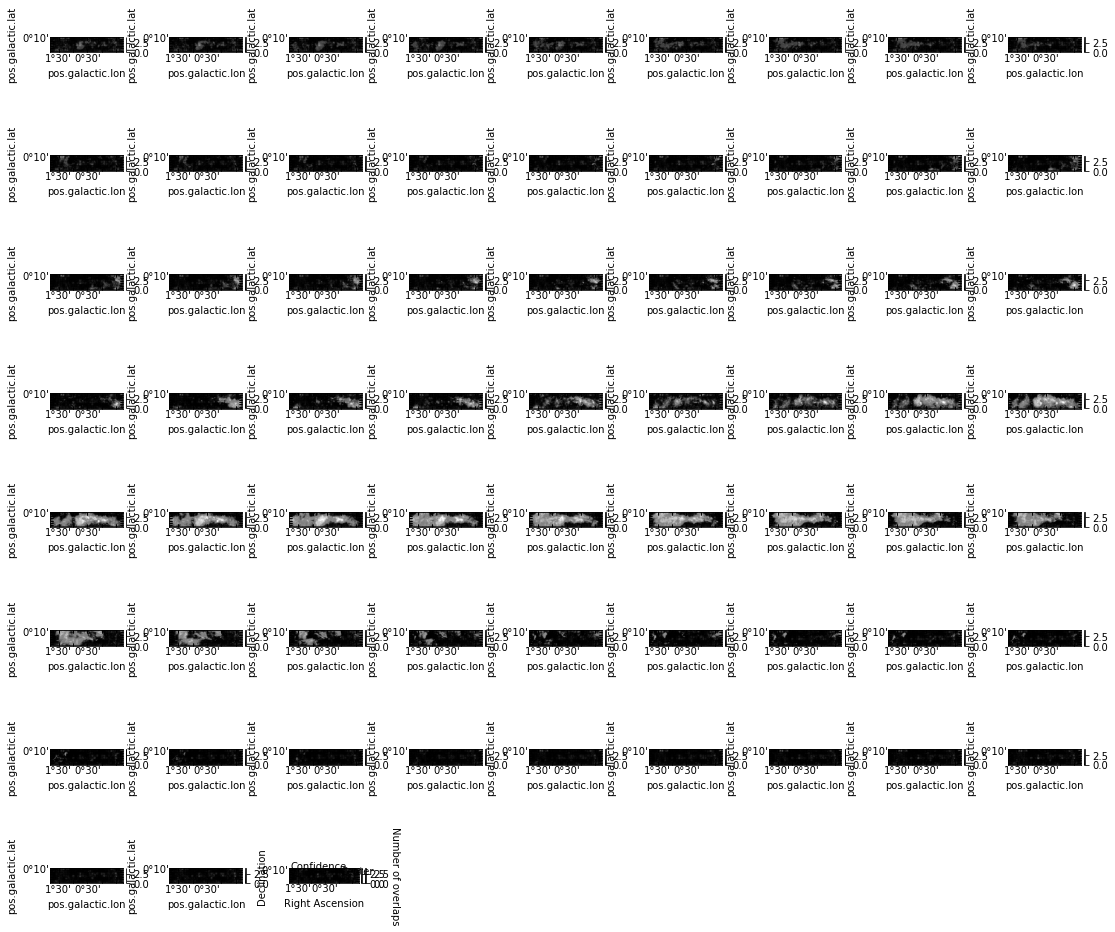

In [10]:
#Find Noise and Confidence, if needed

#Create a mask for all the cubes. 

###################No #If there is another cube that shares at least 67% of the structure, a structure is not to be masked.

#If there are two pixels that have greater than (some) sigma emission we will keep them (at most  (1-P)**2 chance of incorrect label)

#Assign greater confidence to more overlaps


paths = pylab.array(['cmz_HCOp.cube.K-kms.pbcor.fits',
                     'cmz_HCN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13CN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13COp.cube.reproject.K-kms.pbcor.fits'])

FP = pylab.array(['CMZ_3mm_HCO+.fits','CMZ_3mm_HCN.fits','CMZ_3mm_H13CN.fits','CMZ_3mm_H13CO+.fits' ])





SCWs=[]
cds=[]
Ns = [] #get sigmas for all cubes
Absorbtion_mask="No"

#Find noises for first cubes
for i in range(len(FP)):
    sc = SpectralCube.read(paths[i])#FP[i])  
    
    sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    
    sc_slab = sc_kms.spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)  # Crop out velocities we don't care about    
    sc_slab.allow_huge_operations=True    
    
    sc_K_kms = sc_slab.to(u.K)
    
    scW = sc_K_kms.wcs[:][:][0]

    #Find Noise 
    Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
    Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
    NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
    NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
    
        
    
    no = 3
    m=0
    while(True):

        Q = sc_K_kms[int(len(sc_K_kms)-no):len(sc_K_kms),:,:]#NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
        Nsc1 = Q.unmasked_copy()

        if(Absorbtion_mask=="Yes"):
            bp = np.where(Nsc1.hdu.data<0)
            Nsc1.hdu.data[bp]=np.nan
        
            
        #Find StandardDev of this noise cube
        #m=Nsc1.std(axis=0)/u.K
        m=Nsc1.std()/u.K
        
        no+=1
        if(float(np.nanmax(m))!=0.0 and str(float(np.nanmax(m))) != str(np.nan)):
            print(float(np.nanmax(m)),str(float(np.nanmax(m))), str(np.nan),paths[i])
            break
            
    print(np.shape(m),np.shape(Nsc1))
    
    Ns.append(m)
    
#Find noises for pre-masked cubes

'''
for i in range(len(FP)-3,len(FP)):
    sc = SpectralCube.read(FP[i])  
    
    sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    
    sc_slab = sc_kms.spectral_slab(-500. *u.km / u.s, 1000. *u.km / u.s)  # Crop out velocities we don't care about    
    sc_slab.allow_huge_operations=True    
    
    sc_K_kms = sc_slab.to(u.K)
    
    scW = sc_K_kms.wcs[:][:][0]

    #Find Noise. Should be the minimum value since it must be at least 3 sigma to be unmasked
    
    Nsc1 = sc_K_kms.unmasked_copy()
    
    
    bp = np.where(Nsc1.hdu.data<=0)
    
    Nsc1.hdu.data[bp]=np.nan
    m=np.nanmin(Nsc1)/u.K
    print(m,np.shape(Nsc1))
    Ns.append(m)
'''  
    
#print(Ns)

for i in range(1):
    cube=SpectralCube.read(paths[i])
    #print(cube.max(axis=0)[0][0]/u.K,Ns[i][0][0])
    #spatial_mask = cube.max(axis=0)/u.K > 3*Ns[i]        
    
    #cubeM = cube.with_mask(spatial_mask)
    #print(np.shape(cube),np.shape(cubeM))
    cd = cube.hdu.data
    #cds.append(cd)
    #print(len(cds))
    #SCWs.append(cube.wcs[:][:][0])

Confidences=cd

pix = np.where(Confidences != 0)
Confidences[pix] = 0 
#print(Confidences.shape)
print(len(paths),len(FP),len(cds),len(Ns))

for i in range(len(paths)):
    cube=SpectralCube.read(paths[i])
    
    cd = cube.hdu.data
    if(Absorbtion_mask=="No"):
        GP = np.where(abs(cd)>Ns[i]*2)#No abs for only emission
    if(Absorbtion_mask=="Yes"):
        GP = np.where(cd>Ns[i]*2)#No abs for only emission
    print(np.shape(GP))
    print(len(Confidences))
    Confidences[GP]+=1

print(Confidences.shape)


   
print(Confidences.shape)

#Create a plot of all the confidence values

fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map
#print(SCWs[0])
#print(Confidences.shape)0
for n in np.arange(0,int(len(Confidences)/5)):   
    
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(9,9,n+1,projection=scW) # We plot them in a grid    
    #im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*8)
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)
    im = pylab.imshow(np.nanmean(Confidences[n*5:5*n+5],axis=0),cmap='gray',vmin=0,vmax=4)
    cb=pylab.colorbar(im,fraction=0.01,pad=0.04)  
    pylab.tight_layout(w_pad=2,h_pad=1)

'''
ax = pylab.subplot(1,1,1,projection=SCWs[0]) 
RA = ax.coords[0]                                                                  # 
Dec = ax.coords[1]
im = pylab.imshow(Confidences[int(len(Confidences)*.5)],cmap='rainbow')
'''

np.save('Confidence_data_CMZ',Confidences)
np.save('Noises_K_CMZ',Ns)

#Define common structures

center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
y,x = [int(scW.world_to_pixel(center)[0]),int(scW.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=10,labelpad=1)                               
pylab.ylabel('Declination',fontsize=10,labelpad=0)
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)    
cb=pylab.colorbar(im,fraction=0.01,pad=0.04)                                     
cb.set_label(label='Number of overlaps',fontsize=10,rotation=270,labelpad=15) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Confidence',fontsize=10,xy=(0.02,0.91),xycoords="axes fraction")  



In [11]:
CENames=[1,2,3,4]
CCNames=[1,2,3,4]

CENames = np.load("C_Exp_Names_CMZ.npy")
CCNames =  np.load("C_Coef_Names_CMZ.npy")

In [13]:
#HCOp

#print(I)
Num = 0
Ram_Limiter = 1
Name = "HCOp_1_0_Abs_CMZ_100_Runs"


paths = pylab.array(['cmz_HCOp.cube.K-kms.pbcor.fits',
                     'cmz_HCN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13CN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13COp.cube.reproject.K-kms.pbcor.fits'])
NameE = (Name+"Exp")
NameC = (Name+"Coef")
CENames[Num] = NameE
CCNames[Num] = NameC
np.save("C_Exp_Names_CMZ",CENames)
np.save("C_Coef_Names_CMZ",CCNames)

path = paths[Num]
print(path)

Noises = np.load('Noises_K_CMZ.npy')
m = Noises[Num]
#Make subcube
sc = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio").spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)  

scCrop = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scW = scCrop.wcs[:][:][0]

dat = scCrop.hdu.data[:,:,:]

#No size reduction
datn = dat

scF = scCrop


scWCS = scF.wcs[:][:][0]

#Unload all the unimportant vars


header = fits.getheader(path)

#make metadata for the dendrogram
#make metadata for the dendrogram
metadata = {}
metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 

#print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s

#All_SigmasL =  np.array([[]])
#All_SigmasB =  np.array([[]])
#All_RadiiL =  np.array([[]])
#All_RadiiB =  np.array([[]])

Exps =  [[],[],[]]
Coefs = [[],[],[]]


center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
print(center,scWCS.world_to_pixel(center))
x,y = int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])

for Per in range(100):
    
    rng = np.random.default_rng(Per**2)#make a different seed each time
    
    Mod_Dat = datn + rng.normal(0,m,np.shape(datn)) #add a noramlly distributed noise to the data to see if this affects our results (localized at 0, std = noise)
    
    d = astrodendro.Dendrogram.compute(Mod_Dat,min_delta=m,min_value=m*8,min_npix=50) #The main culprit

    vel,NA,na = scF.world[:,0,0]

    ##Analyze dendograms
    print(np.shape(d))


    radsL=np.array([])
    radsB=np.array([])
    sigmasL=np.array([])
    sigmasB=np.array([])

    for t in d.all_structures: 

        I = t.indices()
        s = PPVStatistic(t,metadata=metadata)

        #if(s.v_rms>2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>2*2.0475*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6*1.3807):
        if(s.v_rms>2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>np.sqrt(NBars[0])*2.0475*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
            x_cent = s.x_cen/u.pix
            y_cent = s.y_cen/u.pix

            d0 = 7.2*10**-3*u.Mpc #mpc
            #Find distance to Earth Assuming it lies in the same plane as the center
            D_E = np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((x_cent-x)**2+(y_cent-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )
            #print(D_E)
            if(t.is_leaf):
                radsL=np.append(radsL,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                sigmasL=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)
            if(t.is_branch	):
                radsB=np.append(radsB,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                sigmasB=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)



    from scipy.optimize import curve_fit

    def func(R,a,b):
        return a*R**(b)
    try:
        popt, pcov = curve_fit(func, radsL*10**6, sigmasL)
    except:
        popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
    
    poptB, pcovB = curve_fit(func, radsB*10**6, sigmasB)

    Rcon = np.concatenate((radsL,radsB))
    Scon = np.concatenate((sigmasL,sigmasB))

    poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)
    
    Exps[0].append(popt[1])
    Exps[1].append(poptB[1])
    Exps[2].append(poptCon[1])
    Coefs[0].append(popt[0])
    Coefs[1].append(poptB[0])
    Coefs[2].append(poptCon[0])
    

np.save(CENames[Num],Exps)
np.save(CCNames[Num],Coefs)

cmz_HCOp.cube.K-kms.pbcor.fits
10.55599979032924 pix2
<SkyCoord (Galactic): (l, b) in deg
    (359.94487501, -0.04391769)> (array(561.0341997), array(81.32401635))
(800,)
(804,)
(784,)
(798,)
(779,)
(850,)
(813,)
(784,)
(795,)
(790,)
(763,)
(804,)
(804,)
(802,)
(782,)
(809,)
(794,)
(800,)
(814,)
(806,)
(797,)
(801,)
(831,)
(794,)
(795,)
(823,)
(805,)
(788,)
(811,)
(819,)
(778,)
(803,)
(808,)
(789,)
(819,)
(833,)
(815,)
(810,)
(824,)
(804,)
(814,)
(802,)
(807,)
(817,)
(840,)
(783,)
(797,)
(804,)
(819,)
(810,)
(810,)
(810,)
(780,)
(815,)
(769,)
(829,)
(798,)
(808,)
(822,)
(810,)
(830,)
(817,)
(798,)
(811,)
(784,)
(804,)
(824,)
(800,)
(808,)
(804,)
(807,)
(820,)
(815,)
(830,)
(817,)
(805,)
(824,)
(806,)
(797,)
(783,)
(795,)
(805,)
(823,)
(778,)
(822,)
(792,)
(795,)
(815,)
(829,)
(848,)
(798,)
(775,)
(782,)
(805,)
(802,)
(810,)
(819,)
(779,)
(846,)
(780,)


In [14]:
#HCN 1-0


Num = 1
Ram_Limiter = 1
Name = "HCN_1_0_Abs_CMZ_100_Runs"


paths = pylab.array(['cmz_HCOp.cube.K-kms.pbcor.fits',
                     'cmz_HCN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13CN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13COp.cube.reproject.K-kms.pbcor.fits'])
NameE = (Name+"Exp")
NameC = (Name+"Coef")
CENames[Num] = NameE
CCNames[Num] = NameC
np.save("C_Exp_Names_CMZ",CENames)
np.save("C_Coef_Names_CMZ",CCNames)

path = paths[Num]
print(path)

Noises = np.load('Noises_K_CMZ.npy')
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio").spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)  
sc = Q.unmasked_copy()

scCrop = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scW = scCrop.wcs[:][:][0]

dat = scCrop.hdu.data[:,:,:]

#No size reduction
datn = dat

scF = sc


scWCS = scF.wcs[:][:][0]

#Unload all the unimportant vars
del sc
del paths
del scCrop
del dat

header = fits.getheader(path)

#make metadata for the dendrogram
#make metadata for the dendrogram
metadata = {}
metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 

#print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s

#All_SigmasL =  np.array([[]])
#All_SigmasB =  np.array([[]])
#All_RadiiL =  np.array([[]])
#All_RadiiB =  np.array([[]])

Exps =  [[],[],[]]
Coefs = [[],[],[]]


center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
x,y = [scWCS.world_to_pixel(center)[0],(scWCS.world_to_pixel(center)[1])]
for Per in range(100):
    
    rng = np.random.default_rng(Per**2)#make a different seed each time
    
    Mod_Dat = datn + rng.normal(0,m,np.shape(datn)) #add a noramlly distributed noise to the data to see if this affects our results (localized at 0, std = noise)
    
    d = astrodendro.Dendrogram.compute(Mod_Dat,min_delta=m,min_value=m*8,min_npix=50) #The main culprit

    vel,NA,na = scF.world[:,0,0]

    ##Analyze dendograms
    print(np.shape(d))

    fig = plt.figure(1,figsize=(30,30))

    
    radsL=np.array([])
    radsB=np.array([])
    sigmasL=np.array([])
    sigmasB=np.array([])

    for t in d.all_structures: 

        I = t.indices()
        s = PPVStatistic(t,metadata=metadata)

        #if(s.v_rms>2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>2*2.0475*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6*1.3807):
        if(s.v_rms>2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>np.sqrt(NBars[1])*2.0475*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
            x_cent = s.x_cen/u.pix
            y_cent = s.y_cen/u.pix

            d0 = 7.2*10**-3*u.Mpc #mpc
            #Find distance to Earth Assuming it lies in the same plane as the center
            D_E = np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((x_cent-x)**2+(y_cent-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )
            #print(D_E)
            if(t.is_leaf):
                radsL=np.append(radsL,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                sigmasL=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)
            if(t.is_branch	):
                radsB=np.append(radsB,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                sigmasB=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)



    from scipy.optimize import curve_fit

    def func(R,a,b):
        return a*R**(b)
    try:
        popt, pcov = curve_fit(func, radsL*10**6, sigmasL)
    except:
        popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
    if(len(radsB)>1):
        poptB, pcovB = curve_fit(func, radsB*10**6, sigmasB)
    else:
        poptB, pcovB = [np.nan,np.nan],[np.nan,np.nan]
        

    Rcon = np.concatenate((radsL,radsB))
    Scon = np.concatenate((sigmasL,sigmasB))

    poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)
    
    Exps[0].append(popt[1])
    Exps[1].append(poptB[1])
    Exps[2].append(poptCon[1])
    Coefs[0].append(popt[0])
    Coefs[1].append(poptB[0])
    Coefs[2].append(poptCon[0])
    

np.save(CENames[Num],Exps)
np.save(CCNames[Num],Coefs)

cmz_HCN.cube.reproject.K-kms.pbcor.fits
10.55599979032924 pix2
(1188,)
(1192,)
(1155,)
(1194,)
(1179,)
(1208,)
(1207,)
(1140,)
(1162,)
(1175,)
(1174,)
(1157,)
(1163,)
(1171,)
(1177,)
(1171,)
(1172,)
(1183,)
(1200,)
(1213,)
(1165,)
(1181,)
(1181,)
(1188,)
(1189,)
(1168,)
(1194,)
(1167,)
(1204,)
(1212,)
(1181,)
(1203,)
(1192,)
(1200,)
(1172,)
(1151,)
(1199,)
(1185,)
(1152,)
(1175,)
(1200,)
(1174,)
(1184,)
(1207,)
(1190,)
(1182,)
(1167,)
(1183,)
(1159,)
(1205,)
(1183,)
(1171,)
(1162,)
(1183,)
(1172,)
(1189,)
(1177,)
(1172,)
(1176,)
(1189,)
(1179,)
(1197,)
(1165,)
(1200,)
(1203,)
(1188,)
(1172,)
(1207,)
(1193,)
(1180,)
(1190,)
(1192,)
(1184,)
(1209,)
(1184,)
(1149,)
(1193,)
(1203,)
(1174,)
(1189,)
(1178,)
(1212,)
(1190,)
(1220,)
(1182,)
(1182,)
(1175,)
(1148,)
(1212,)
(1193,)
(1181,)
(1187,)
(1221,)
(1173,)
(1171,)
(1187,)
(1201,)
(1171,)
(1194,)
(1186,)


<Figure size 2160x2160 with 0 Axes>

In [15]:
#H13CN 


Num = 2
Ram_Limiter = 1
Name = "H13CN_1_0_Abs_CMZ_100_Runs"


paths = pylab.array(['cmz_HCOp.cube.K-kms.pbcor.fits',
                     'cmz_HCN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13CN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13COp.cube.reproject.K-kms.pbcor.fits'])
NameE = (Name+"Exp")
NameC = (Name+"Coef")
CENames[Num] = NameE
CCNames[Num] = NameC
np.save("C_Exp_Names_CMZ",CENames)
np.save("C_Coef_Names_CMZ",CCNames)

path = paths[Num]
print(path)
H13COP_MASK = np.load('H13COP_MASK.npy')
Noises = np.load('Noises_K_CMZ.npy')
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio").spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)   
sc = Q.unmasked_copy()

scCrop = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scW = scCrop.wcs[:][:][0]

dat = scCrop.hdu.data[:,:,:]

BP = np.where(H13COP_MASK<1)#Mask the cube where HCO+ >2 sigma is a requirement

sc.hdu.data[BP]=np.nan
#No size reduction
datn = dat

scF = sc


scWCS = scF.wcs[:][:][0]

#Unload all the unimportant vars
del sc
del paths
del scCrop
del dat

header = fits.getheader(path)

#make metadata for the dendrogram
#make metadata for the dendrogram
metadata = {}
metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 

#print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s

#All_SigmasL =  np.array([[]])
#All_SigmasB =  np.array([[]])
#All_RadiiL =  np.array([[]])
#All_RadiiB =  np.array([[]])

Exps =  [[],[],[]]
Coefs = [[],[],[]]


center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
x,y = [scWCS.world_to_pixel(center)[0],(scWCS.world_to_pixel(center)[1])]
for Per in range(100):
    
    rng = np.random.default_rng(Per**2)#make a different seed each time
    
    Mod_Dat = datn + rng.normal(0,m,np.shape(datn)) #add a noramlly distributed noise to the data to see if this affects our results (localized at 0, std = noise)
    
    d = astrodendro.Dendrogram.compute(Mod_Dat,min_delta=m,min_value=m*2,min_npix=50) #The main culprit

    vel,NA,na = scF.world[:,0,0]

    ##Analyze dendograms
    print(np.shape(d))

    fig = plt.figure(1,figsize=(30,30))

    radsL=np.array([])
    radsB=np.array([])
    sigmasL=np.array([])
    sigmasB=np.array([])

    for t in d.all_structures: 

        I = t.indices()
        s = PPVStatistic(t,metadata=metadata)

        #if(s.v_rms>2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>2*2.0475*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6*1.3807):
        if(s.v_rms>2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>np.sqrt(NBars[2])*2.0475*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
            x_cent = s.x_cen/u.pix
            y_cent = s.y_cen/u.pix

            d0 = 7.2*10**-3*u.Mpc #mpc
            #Find distance to Earth Assuming it lies in the same plane as the center
            D_E = np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((x_cent-x)**2+(y_cent-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )
            #print(D_E)
            if(t.is_leaf):
                radsL=np.append(radsL,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                sigmasL=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)
            if(t.is_branch	):
                radsB=np.append(radsB,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                sigmasB=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)



    from scipy.optimize import curve_fit

    def func(R,a,b):
        return a*R**(b)
    try:
        popt, pcov = curve_fit(func, radsL*10**6, sigmasL)
    except:
        popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
    try:
        poptB, pcovB = curve_fit(func, radsB*10**6, sigmasB)
    except:
        poptB, pcovB = [np.nan,np.nan],[np.nan,np.nan]
        

    Rcon = np.concatenate((radsL,radsB))
    Scon = np.concatenate((sigmasL,sigmasB))
    try:
        poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)
    except:
        poptCon, pcovCon =np.nan,np.nan
    try:
        Exps[0].append(popt[1])
        Coefs[0].append(popt[0])
    except:
        Exps[0].append(np.nan)
        Coefs[0].append(np.nan)
    try:
        Exps[1].append(poptB[1])
        Coefs[1].append(poptB[0])
    except:
        Exps[1].append(np.nan)
        Coefs[1].append(np.nan)
    try:
        Exps[2].append(poptCon[1])
        Coefs[2].append(poptCon[0])
    except:
        Exps[2].append(np.nan)
        Coefs[2].append(np.nan)


np.save(CENames[Num],Exps)
np.save(CCNames[Num],Coefs)

cmz_H13CN.cube.reproject.K-kms.pbcor.fits
10.55599979032924 pix2
(2736,)
(2728,)
(2687,)
(2754,)
(2752,)
(2766,)
(2733,)
(2760,)
(2799,)
(2725,)
(2822,)
(2821,)
(2706,)
(2805,)
(2739,)
(2758,)
(2762,)
(2702,)
(2691,)
(2722,)
(2712,)
(2803,)
(2715,)
(2724,)
(2789,)
(2673,)
(2711,)
(2797,)
(2764,)
(2755,)
(2706,)
(2709,)
(2823,)
(2664,)
(2742,)
(2810,)
(2830,)
(2776,)
(2854,)
(2752,)
(2743,)
(2772,)
(2814,)
(2751,)
(2779,)
(2748,)
(2712,)
(2809,)
(2839,)
(2819,)
(2778,)
(2759,)
(2802,)
(2769,)
(2691,)
(2739,)
(2838,)
(2715,)
(2759,)
(2734,)
(2760,)
(2806,)
(2762,)
(2820,)
(2698,)
(2728,)
(2866,)
(2753,)
(2859,)
(2853,)
(2785,)
(2735,)
(2736,)
(2841,)
(2743,)
(2791,)
(2743,)
(2744,)
(2787,)
(2777,)
(2778,)
(2815,)
(2806,)
(2789,)
(2737,)
(2799,)
(2843,)
(2744,)
(2685,)
(2783,)
(2765,)
(2795,)
(2745,)
(2757,)
(2781,)
(2839,)
(2792,)
(2732,)
(2748,)
(2821,)


<Figure size 2160x2160 with 0 Axes>

In [16]:
#H13CoP


Num = 3
Ram_Limiter = 1
Name = "H13CoP_1_0_Abs_CMZ_100_Runs"


paths = pylab.array(['cmz_HCOp.cube.K-kms.pbcor.fits',
                     'cmz_HCN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13CN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13COp.cube.reproject.K-kms.pbcor.fits'])
NameE = (Name+"Exp")
NameC = (Name+"Coef")
CENames[Num] = NameE
CCNames[Num] = NameC
np.save("C_Exp_Names_CMZ",CENames)
np.save("C_Coef_Names_CMZ",CCNames)

path = paths[Num]
print(path)

Noises = np.load('Noises_K_CMZ.npy')
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio").spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)    
sc = Q.unmasked_copy()

scCrop = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scW = scCrop.wcs[:][:][0]

dat = scCrop.hdu.data[:,:,:]

#No size reduction
datn = dat

scF = sc


scWCS = scF.wcs[:][:][0]

#Unload all the unimportant vars
del sc
del paths
del scCrop
del dat

header = fits.getheader(path)

#make metadata for the dendrogram
#make metadata for the dendrogram
metadata = {}
metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 

#print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s

#All_SigmasL =  np.array([[]])
#All_SigmasB =  np.array([[]])
#All_RadiiL =  np.array([[]])
#All_RadiiB =  np.array([[]])

Exps =  [[],[],[]]
Coefs = [[],[],[]]


center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
x,y = [scWCS.world_to_pixel(center)[0],(scWCS.world_to_pixel(center)[1])]

for Per in range(100):
    
    rng = np.random.default_rng(Per**2)#make a different seed each time
    
    Mod_Dat = datn + rng.normal(0,m,np.shape(datn)) #add a noramlly distributed noise to the data to see if this affects our results (localized at 0, std = noise)
    
    d = astrodendro.Dendrogram.compute(Mod_Dat,min_delta=m,min_value=m*8,min_npix=50) #The main culprit

    vel,NA,na = scF.world[:,0,0]

    ##Analyze dendograms
    print(np.shape(d))

    fig = plt.figure(1,figsize=(30,30))

    
    radsL=np.array([])
    radsB=np.array([])
    sigmasL=np.array([])
    sigmasB=np.array([])

    for t in d.all_structures: 

        I = t.indices()
        s = PPVStatistic(t,metadata=metadata)

        #if(s.v_rms>2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>2*2.0475*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6*1.3807):
        if(s.v_rms>2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>np.sqrt(NBars[3])*2.0475*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
            x_cent = s.x_cen/u.pix
            y_cent = s.y_cen/u.pix


            #Find distance to Earth Assuming it lies in the same plane as the center
            D_E = np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((x_cent-x)**2+(y_cent-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )
            #print(D_E)
            if(t.is_leaf):
                radsL=np.append(radsL,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                sigmasL=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)
            if(t.is_branch	):
                radsB=np.append(radsB,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                sigmasB=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)



    from scipy.optimize import curve_fit

    def func(R,a,b):
        return a*R**(b)
    try:
        popt, pcov = curve_fit(func, radsL*10**6, sigmasL)
    except:
        popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
    try:
        poptB, pcovB = curve_fit(func, radsB*10**6, sigmasB)
    except:
        poptB, pcovB = [np.nan,np.nan],[np.nan,np.nan]
        

    Rcon = np.concatenate((radsL,radsB))
    Scon = np.concatenate((sigmasL,sigmasB))
    try:
        poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)
    except:
        poptCon, pcovCon =np.nan,np.nan
    try:
        Exps[0].append(popt[1])
        Coefs[0].append(popt[0])
    except:
        Exps[0].append(np.nan)
        Coefs[0].append(np.nan)
    try:
        Exps[1].append(poptB[1])
        Coefs[1].append(poptB[0])
    except:
        Exps[1].append(np.nan)
        Coefs[1].append(np.nan)
    try:
        Exps[2].append(poptCon[1])
        Coefs[2].append(poptCon[0])
    except:
        Exps[2].append(np.nan)
        Coefs[2].append(np.nan)
    

np.save(CENames[Num],Exps)
np.save(CCNames[Num],Coefs)

cmz_H13COp.cube.reproject.K-kms.pbcor.fits
10.55599979032924 pix2
(79,)
(81,)
(77,)
(74,)
(71,)
(76,)
(88,)
(85,)
(86,)
(80,)
(82,)
(80,)
(75,)
(81,)
(83,)
(80,)
(79,)
(83,)
(85,)
(82,)
(84,)
(82,)
(86,)
(79,)
(85,)
(77,)
(76,)
(73,)
(80,)
(82,)
(85,)
(75,)
(82,)
(87,)
(78,)
(83,)
(83,)
(76,)
(86,)
(74,)
(85,)
(79,)
(80,)
(83,)
(83,)
(74,)
(83,)
(81,)
(82,)
(78,)
(79,)
(92,)
(81,)
(78,)
(85,)
(85,)
(80,)
(80,)
(79,)
(83,)
(78,)
(82,)
(81,)
(79,)
(89,)
(84,)
(79,)
(82,)
(89,)
(89,)
(74,)
(86,)
(73,)
(78,)
(82,)
(79,)
(82,)
(81,)
(79,)
(76,)
(86,)
(80,)
(88,)
(79,)
(83,)
(76,)
(83,)
(83,)
(84,)
(90,)
(74,)
(85,)
(80,)
(83,)
(78,)
(84,)
(81,)
(76,)
(80,)
(81,)


<Figure size 2160x2160 with 0 Axes>

In [60]:
CENames_CMZ =np.load("C_Exp_Names_CMZ.npy")
CCNames_CMZ = np.load("C_Coef_Names_CMZ.npy")


p = np.load("C_Exp_Names.npy")

CENames_NGC = [p[9],p[10],p[8]]
p = np.load("C_Coef_Names.npy")

CCNames_NGC = [p[9],p[10],p[8]]
for i in range(len(CENames_CMZ)):
    
    CMZ_C = np.load((CCNames_CMZ[i]+".npy"))[2]#For all structures
    CMZ_E = np.load((CENames_CMZ[i]+".npy"))[2]
    
    NGC_C = np.load((CCNames_NGC[i]+".npy"))[2]
    NGC_E = np.load((CENames_NGC[i]+".npy"))[2]
    
    
    print(CCNames_CMZ[i],CENames_CMZ[i])
    
    print(CCNames_NGC[i],CENames_NGC[i])
    
    print("CMZ, a=",np.mean(CMZ_C),"+-",np.std(CMZ_C),"b=",np.mean(CMZ_E),"+-",np.std(CMZ_E))
    print("NGC, a=",np.mean(NGC_C),"+-",np.std(NGC_C),"b=",np.mean(NGC_E),"+-",np.std(NGC_E))
    
    
    

HCOp_4_3_Abs_CMZ_100_RunsCoef HCOp_4_3_Abs_CMZ_100_RunsExp
HCOp-J4-3_Dend_Abs_100_RunsCoef HCOp-J4-3_Dend_Abs_100_RunsExp
CMZ, a= 5.332027163557812 +- 0.16195537953565178 b= 0.5274990755261506 +- 0.00946033979191493
NGC, a= 5.758227779545085 +- 0.11795410478418718 b= 0.6798094513461355 +- 0.006051173081130981
HCN_4_3_Abs_CMZ_100_RunsCoef HCN_4_3_Abs_CMZ_100_RunsExp
HCN4-3_Abs_100_RunsCoef HCN4-3_Abs_100_RunsExp
CMZ, a= 5.02085840014815 +- 0.17365068522687974 b= 0.5741160834606559 +- 0.012215571566903498
NGC, a= 6.0133691358255525 +- 0.1125637113094869 b= 0.6482018281769861 +- 0.005083137089613568


FileNotFoundError: [Errno 2] No such file or directory: 'H13CN4_3_Abs_100_RunsCoef.npy'

['HCOp_1_0_Abs_CMZRadii' 'HCN_1_0_Abs_CMZRadii' '3'
 'H13CoP_1_0_Abs_CMZRad' '5']


FileNotFoundError: [Errno 2] No such file or directory: '2_Leaves.npy'

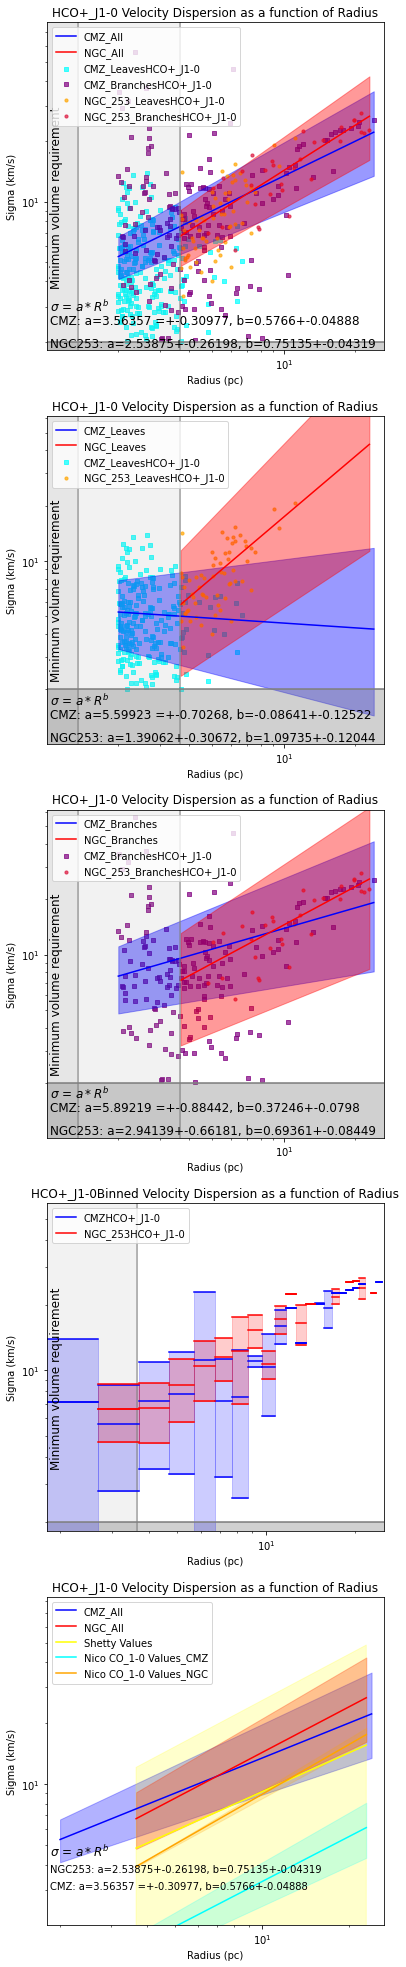

In [7]:
#Load in data from the 100 noise_modified runs
CENames_CMZ =np.load("C_Exp_Names_CMZ.npy")
CCNames_CMZ = np.load("C_Coef_Names_CMZ.npy")


p = np.load("C_Exp_Names.npy")

#CENames_NGC = [p[9],p[10],p[8],p[5]]
p2 = np.load("C_Coef_Names.npy")

#CCNames_NGC = [p[9],p[10],p[8],p[5]]
CENames_NGC = [p[0],p[1],p[2],p[5]]
#print(CENames_NGC,CCNames_NGC)

CCNames_NGC = [p2[0],p2[1],p2[2],p2[5]]
    
#Get data for the actual dendograms
    
    
RNames = np.load("RNames_CMZ.npy")
SNames = np.load("SNames_CMZ.npy")
print(RNames)
CMZLs = ["HCO+_J1-0","HCN_J1-0","H13CN_J1-0","H13CO+_J1-0"]
NGCRNames = np.load("RNames.npy")
NGCSNames = np.load("SNames.npy")

#ONGCR = [NGCRNames[9],NGCRNames[10],NGCRNames[8],NGCRNames[5]]
#ONGCS = [NGCSNames[9],NGCSNames[10],NGCSNames[8],NGCSNames[5]]
ONGCR = [NGCRNames[0],NGCRNames[1],NGCRNames[2],NGCRNames[5]]
ONGCS = [NGCSNames[0],NGCSNames[1],NGCSNames[2],NGCSNames[5]]


Bars = np.load("CZM_Beam_Area_Ratios.npy")
NBars = np.load("NGC_Beam_Area_Ratios.npy")

SpecRes = np.load("CZM_Sres.npy")
NSpecRes = np.load("NGC_Sres.npy")

SpRes= np.load("CZM_Spres.npy")
NSpRes = np.load("NGC_Spres.npy")

#for i in range(len(RNames)):
fig = plt.figure(1,figsize=(35,35))


for i in range(4):
    #make minimum space line
    
    ysp=2#SpecRes[i]
    xsp=SpRes[i]*np.sqrt(Bars[i])#SpRes[i]
    Nysp=2#NSpecRes[i]
    Nxsp=NSpRes[i]*np.sqrt(NBars[i])
    
    
    
        
    xsps=[]

    ysps=[]

    line=[]
    minsigs=[]
    Nxsps=[]

    Nysps=[]

    
    Nminsigs=[]
    zeros=[]
    
    rs=np.linspace(0.1,500,100)
    L=np.linspace(-1,20,10)
    for t in range(100):
        ps = 0
        xsps.append(xsp)
        ysps.append(ysp)
        
        Nxsps.append(Nxsp)
        Nysps.append(Nysp)
        
        Nminsigs.append(np.roots([rs[t]**2,-NSpecRes[i]*3*NSpRes[i]**2])[0]) #Solve for the minimum sigma value for a given radius
        minsigs.append(np.roots([rs[t]**2,-SpecRes[i]*3*SpRes[i]**2*2.0475**2*1.3807])[0])
        
        line.append(rs[t])
        zeros.append(-1)
    
    #print(RNames,SNames,CMZLs,NGCRNames,NGCSNames)
    rnameNA = RNames[i]+"_NA"
    snameNA = SNames[i]+"_NA"
    
    NGCrnameNA = ONGCR[i]+"_NA"
    NGCsnameNA = ONGCS[i]+"_NA"
    
    radsNA = np.load(rnameNA)*10**6#pc
    sigsNA = np.load(snameNA)
    
    radsNGCNA = np.load(NGCrnameNA)*10**6
    sigsNGCNA = np.load(NGCsnameNA)
    
    
    
    rnameL=RNames[i]+"_Leaves.npy"
    snameL=SNames[i]+"_Leaves.npy"
    rnameB=RNames[i]+"_Branches.npy"
    snameB=SNames[i]+"_Branches.npy"
    
    NGCrnameL=ONGCR[i]+"_Leaves.npy"
    NGCsnameL=ONGCS[i]+"_Leaves.npy"
    NGCrnameB=ONGCR[i]+"_Branches.npy"
    NGCsnameB=ONGCS[i]+"_Branches.npy"
    
    radsL = np.load(rnameL)*10**6#pc
    sigsL = np.load(snameL)
    radsB = np.load(rnameB)*10**6#pc
    sigsB = np.load(snameB)
    
    radsNGCL = np.load(NGCrnameL)*10**6
    sigsNGCL = np.load(NGCsnameL)
    radsNGCB = np.load(NGCrnameB)*10**6
    sigsNGCB = np.load(NGCsnameB)
    
    radsNGC=np.concatenate((radsNGCL,radsNGCB))
    sigsNGC = np.concatenate((sigsNGCL,sigsNGCB))
    rads,sigs=np.concatenate((radsL,radsB)), np.concatenate((sigsL,sigsB))
    
    from scipy.optimize import curve_fit
    
    def func(R,a,b):
        return a*R**(b)
    #print(Bin_Rads,Bin_Sigs)
    (popt2, pcov2),(poptT, pcovT) =(curve_fit(func, radsB, sigsB)),(curve_fit(func, rads,sigs))
    
    try:
        (popt, pcov) = (curve_fit(func, radsL, sigsL))
    except:
        (popt, pcov) = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
    (Npopt2, Npcov2),(NpoptT, NpcovT) = (curve_fit(func, radsNGCB, sigsNGCB)),(curve_fit(func, radsNGC,sigsNGC ))
    
    try:
        (Npopt, Npcov) = (curve_fit(func, radsNGCL, sigsNGCL))
    except:
        (Npopt, Npcov) =[np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
           
    poptNA,pcovNA = curve_fit(func, radsNA, sigsNA)
    NpoptNA,NpcovNA = curve_fit(func, radsNGCNA, sigsNGCNA)
    
    #Get average fit data for the Noise-modified runs
    CMZ_C = np.load((CCNames_CMZ[i]+".npy"))[2]#For all structures
    CMZ_E = np.load((CENames_CMZ[i]+".npy"))[2]
    
    C_Cmz,C_Cmz_Err = np.nanmean(CMZ_C),np.std(CMZ_C)
    E_Cmz,E_Cmz_Err = np.nanmean(CMZ_E),np.std(CMZ_E)
    
    
    NGC_C = np.load((CCNames_NGC[i]+".npy"))[2]
    NGC_E = np.load((CENames_NGC[i]+".npy"))[2]
    #print(NGC_C,NGC_E)
    C_Ngc,C_Ngc_Err = np.nanmean(NGC_C),np.std(NGC_C)
    E_Ngc,E_Ngc_Err = np.nanmean(NGC_E),np.std(NGC_E)
    
    axA = pylab.subplot(6,5, i+1)
    axL = pylab.subplot(6,5, i+7)
    axB = pylab.subplot(6,5, i+13)
    
    axNM = pylab.subplot(6,5, i+19)
    
    axNA = pylab.subplot(6,5, i+25)
    #No abs both
    xsNAp = axNA.scatter(radsNA, sigsNA,c="Dark Blue",alpha=.7,label=("CMZ_No_Abs_All"+CMZLs[i]),marker='x',s=10,facecolors='Dark Blue')
    NxsNAp = axNA.scatter(radsNGCNA, sigsNGCNA,c="Dark Red",alpha=.7,label=("NGC_No_Abs_All"+CMZLs[i]),marker='x',s=10,facecolors='Dark Blue')
    #leaves and branches CMZ
    xp1L = axL.scatter(radsL, sigsL,c="Cyan",alpha=.7,label=("CMZ_Leaves"+CMZLs[i]),marker='s',s=10,facecolors='none')
    xp1B = axB.scatter(radsB, sigsB,c="Purple",alpha=.7,label=("CMZ_Branches"+CMZLs[i]),marker='s',s=10,facecolors='black')
    xp1AL = axA.scatter(radsL, sigsL,c="Cyan",alpha=.7,label=("CMZ_Leaves"+CMZLs[i]),marker='s',s=10,facecolors='none')
    xp1AB = axA.scatter(radsB, sigsB,c="Purple",alpha=.7,label=("CMZ_Branches"+CMZLs[i]),marker='s',s=10,facecolors='black')
    
    xs=np.linspace(np.nanmin(rads),np.nanmax(rads),50)
    ysL,ysB,ysT=func(xs,popt[0],popt[1]),func(xs,popt2[0],popt2[1]), func(xs,poptT[0],poptT[1])
    xpaL,xpaB,xpaT = axL.plot(xs,ysL,c='Blue',label="CMZ_Leaves"),axB.plot(xs,ysB,c='Blue',label="CMZ_Branches"),axA.plot(xs,ysT,c='Blue',label='CMZ_All')
    
    
    
    er_r=2
    yusL,yusB,yusT  = func(xs, popt[0]+np.sqrt(pcov[0][0])*er_r,popt[1]+np.sqrt(pcov[1][1])*er_r),func(xs, popt2[0]+np.sqrt(pcov2[0][0])*er_r,popt2[1]+np.sqrt(pcov2[1][1])*er_r),func(xs, poptT[0]+np.sqrt(pcovT[0][0])*er_r,poptT[1]+np.sqrt(pcovT[1][1])*er_r)
    ylsL,ylsB,ylsT  = func(xs, popt[0]-np.sqrt(pcov[0][0])*er_r,popt[1]-np.sqrt(pcov[1][1])*er_r),func(xs, popt2[0]-np.sqrt(pcov2[0][0])*er_r,popt2[1]-np.sqrt(pcov2[1][1])*er_r),func(xs, poptT[0]-np.sqrt(pcovT[0][0])*er_r,poptT[1]-np.sqrt(pcovT[1][1])*er_r)
    xpaFL,xpaFB,xpaFT = axL.fill_between(xs,ylsL,yusL,color="Blue",alpha=.4),axB.fill_between(xs,ylsB,yusB,color="Blue",alpha=.4),axA.fill_between(xs,ylsT,yusT,color="Blue",alpha=.4)
    
    
    ysNM = func(xs,C_Cmz,E_Cmz)
    ysNM_U = func(xs, C_Cmz+(C_Cmz_Err)*er_r,E_Cmz+(E_Cmz_Err)*er_r)
    ysNM_L = func(xs, C_Cmz-(C_Cmz_Err)*er_r,E_Cmz-(E_Cmz_Err)*er_r)
    
    cmzT2F = axNM.fill_between(xs,ylsT,yusT,color="Blue",alpha=.3)
    cmzT2 = axNM.plot(xs,ysT,c='Blue',label='CMZ_All')
    
    #cmzNMF = axNM.fill_between(xs,ysNM_L,ysNM_U,color="Purple",alpha=.3)
    #cmzNM = axNM.plot(xs,ysNM,c='Purple',label='Noise-modified CMZ average of 100 runs (All)')
    
    if(i==1):
        percent = 1
    else:
        percent = 1
    Nxp1L = axL.scatter(radsNGCL[0:int((len(radsNGCL)-1)*percent)], sigsNGCL[0:int((len(sigsNGCL)-1)*percent)],c="Orange",alpha=.7,label=("NGC_253_Leaves"+CMZLs[i]),marker='o',s=10,facecolors='none')
    Nxp1B = axB.scatter(radsNGCB[0:int((len(radsNGCB)-1)*percent)], sigsNGCB[0:int((len(sigsNGCB)-1)*percent)],c="Crimson",alpha=.7,label=("NGC_253_Branches"+CMZLs[i]),marker='o',s=10,facecolors='black')
    Nxp1AL = axA.scatter(radsNGCL[0:int((len(radsNGCL)-1)*percent)], sigsNGCL[0:int((len(sigsNGCL)-1)*percent)],c="Orange",alpha=.7,label=("NGC_253_Leaves"+CMZLs[i]),marker='o',s=10,facecolors='none')
    Nxp1AB = axA.scatter(radsNGCB[0:int((len(radsNGCB)-1)*percent)], sigsNGCB[0:int((len(sigsNGCB)-1)*percent)],c="Crimson",alpha=.7,label=("NGC_253_Branches"+CMZLs[i]),marker='o',s=10,facecolors='black')
    
    Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
    NysL,NysB,NysT=func(Nxs,Npopt[0],Npopt[1]),func(Nxs,Npopt2[0],Npopt2[1]), func(Nxs,NpoptT[0],NpoptT[1])
    NxpaL,NxpaB,NxpaT = axL.plot(Nxs,NysL,c='Red',label="NGC_Leaves"),axB.plot(Nxs,NysB,c='Red',label="NGC_Branches"),axA.plot(Nxs,NysT,c='Red',label='NGC_All')
    
    er_r=2
    NyusL,NyusB,NyusT  = func(Nxs, Npopt[0]+np.sqrt(Npcov[0][0])*er_r,Npopt[1]+np.sqrt(Npcov[1][1])*er_r),func(Nxs, Npopt2[0]+np.sqrt(Npcov2[0][0])*er_r,Npopt2[1]+np.sqrt(Npcov2[1][1])*er_r),func(Nxs, NpoptT[0]+np.sqrt(NpcovT[0][0])*er_r,NpoptT[1]+np.sqrt(NpcovT[1][1])*er_r)
    NylsL,NylsB,NylsT  = func(Nxs, Npopt[0]-np.sqrt(Npcov[0][0])*er_r,Npopt[1]-np.sqrt(Npcov[1][1])*er_r),func(Nxs, Npopt2[0]-np.sqrt(Npcov2[0][0])*er_r,Npopt2[1]-np.sqrt(Npcov2[1][1])*er_r),func(Nxs, NpoptT[0]-np.sqrt(NpcovT[0][0])*er_r,NpoptT[1]-np.sqrt(NpcovT[1][1])*er_r)
    NxpaFL,NxpaFB,NxpaFT = axL.fill_between(Nxs,NylsL,NyusL,color="Red",alpha=.4),axB.fill_between(Nxs,NylsB,NyusB,color="Red",alpha=.4),axA.fill_between(Nxs,NylsT,NyusT,color="Red",alpha=.4)
    
    
    
    #Plot NM data
    
    NysNM = func(Nxs,C_Ngc,E_Ngc)
    NysNM_U = func(Nxs, C_Ngc+(C_Ngc_Err)*er_r,E_Ngc+(E_Ngc_Err)*er_r)
    NysNM_L = func(Nxs, C_Ngc-(C_Ngc_Err)*er_r,E_Ngc-(E_Ngc_Err)*er_r)
    
    ngcT2F = axNM.fill_between(Nxs,NylsT,NyusT,color="Red",alpha=.3)
    ngcT2 = axNM.plot(Nxs,NysT,c='Red',label='NGC_All')
    
    Shetty_Exp = [0.64,0.46,.78,-5]
    Shetty_exp_errs = .06
    
    ShettyCoefs = [2.1,3.8,2.6,-5]
    ShettyCoefsErrs = 1.2
    SP = func(Nxs,ShettyCoefs[i],Shetty_Exp[i])
    SPU = func(Nxs,ShettyCoefs[i]+ShettyCoefsErrs*er_r,Shetty_Exp[i] + Shetty_exp_errs*er_r)
    SPL = func(Nxs,ShettyCoefs[i]-ShettyCoefsErrs*er_r,Shetty_Exp[i] - Shetty_exp_errs*er_r)
    ShettyNM = axNM.plot(Nxs,SP,c='Yellow',label='Shetty Values')
    ShettyFill = axNM.fill_between(Nxs,SPL,SPU,color="Yellow",alpha=.2)
    
    NicoCO = .74
    NicoCOErr=.04
    NicoCO_10= 3.3
    NicoCO_10Err= .4
    
    def NicoCOCoef(sig10,exp):
        return sig10/10**exp
    NNicoCO = .82
    NNicoCOErr=.02
    NNicoCO_10= 8.9
    NNicoCO_10Err= .2
    
    NI = func(Nxs,NicoCOCoef(NicoCO_10,NicoCO),NicoCO)
    NIU = func(Nxs,NicoCOCoef(NicoCO_10+NicoCO_10Err*er_r,NicoCO+NicoCOErr*er_r),NicoCO+ NicoCOErr*er_r)
    NIL = func(Nxs,NicoCOCoef(NicoCO_10-NicoCO_10Err*er_r,NicoCO-NicoCOErr*er_r),NicoCO- NicoCOErr*er_r)
    
    NicoNM = axNM.plot(Nxs,NI,c='Cyan',label='Nico CO_1-0 Values_CMZ')
    NicoFill = axNM.fill_between(Nxs,NIL,NIU,color="Cyan",alpha=.2)
    
    NNI = func(Nxs,NicoCOCoef(NNicoCO_10,NNicoCO),NNicoCO)
    NNIU = func(Nxs,NicoCOCoef(NNicoCO_10+NNicoCO_10Err*er_r,NNicoCO+NNicoCOErr*er_r),NNicoCO+ NNicoCOErr*er_r)
    NNIL = func(Nxs,NicoCOCoef(NNicoCO_10-NNicoCO_10Err*er_r,NNicoCO-NNicoCOErr*er_r),NNicoCO- NNicoCOErr*er_r)
    
    NNicoNM = axNM.plot(Nxs,NNI,c='Orange',label='Nico CO_1-0 Values_NGC')
    NNicoFill = axNM.fill_between(Nxs,NNIL,NNIU,color="Orange",alpha=.2)
    
    
                         
    #ngcNMF = axNM.fill_between(Nxs,NysNM_L,NysNM_U,color="Black",alpha=.2)
    #ngcNM = axNM.plot(Nxs,NysNM,c='Black',label='Noise-modified NGC average of 100 runs (All)')
        
    
    #######################################
    #minVol = axA.plot(line,minsigs,color="gray",alpha=.7)
    #NminVol = axA.plot(line,Nminsigs,color="gray",alpha=.7)
    #minVol = axA.fill_between(line,zeros,minsigs,color="gray",alpha=.2)
    
    #minVol = axB.plot(line,minsigs,color="gray",alpha=.7)
    #NminVol = axB.plot(line,Nminsigs,color="gray",alpha=.7)
    #minVol = axB.fill_between(line,zeros,minsigs,color="gray",alpha=.2)
    
    #minVol = axL.plot(line,minsigs,color="gray",alpha=.7)
    #NminVol = axL.plot(line,Nminsigs,color="gray",alpha=.7)
    #minVol = axL.fill_between(line,zeros,minsigs,color="gray",alpha=.2)
    
    
    axL.set_xlabel("Radius (pc)")
    axL.set_ylabel("Sigma (km/s)")
    axB.set_xlabel("Radius (pc)")
    axB.set_ylabel("Sigma (km/s)")
    axA.set_xlabel("Radius (pc)")
    axA.set_ylabel("Sigma (km/s)")
    axNM.set_xlabel("Radius (pc)")
    axNM.set_ylabel("Sigma (km/s)")
    axA.set_yscale('log')
    axA.set_xscale('log')
    axB.set_yscale('log')
    axB.set_xscale('log')
    axL.set_yscale('log')
    axL.set_xscale('log')
    axNM.set_yscale('log')
    axNM.set_xscale('log')
    axA.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=12,xy=(0.01,0.12),xycoords="axes fraction")  
    axB.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=12,xy=(0.01,0.12),xycoords="axes fraction")  
    axL.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=12,xy=(0.01,0.12),xycoords="axes fraction")  
    axNM.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=12,xy=(0.01,0.21),xycoords="axes fraction")
    stL= ("CMZ: a="+str(round(popt[0],5))+" =+-" + str(round(np.sqrt(pcov[0][0]),5)) +", b="+str(round(popt[1],5))+"+-" + str(round(np.sqrt(pcov[1][1]),5)) )
    stB= ("CMZ: a="+str(round(popt2[0],5))+" =+-" + str(round(np.sqrt(pcov2[0][0]),5)) +", b="+str(round(popt2[1],5))+"+-" + str(round(np.sqrt(pcov2[1][1]),5)) )
    stA= ("CMZ: a="+str(round(poptT[0],5))+" =+-" + str(round(np.sqrt(pcovT[0][0]),5)) +", b="+str(round(poptT[1],5))+"+-" + str(round(np.sqrt(pcovT[1][1]),5)) )
    stNM= ("CMZ (NM avg): a="+str(round(C_Cmz,5))+" =+-" + str(round(C_Cmz_Err,5)) +", b="+str(round(E_Cmz,5))+"+-" + str(round(E_Cmz_Err,5)) )
    axA.set_xlim(np.nanmin(rads)*.5,np.nanmax(rads)*1.1)
    axA.set_ylim(np.nanmin(sigs)*.9,np.nanmax(sigs)*1.4)
    axL.set_xlim(np.nanmin(rads)*.5,np.nanmax(rads)*1.1)
    axL.set_ylim(np.nanmin(sigs)*.5,np.nanmax(sigs)*1.1)
    axB.set_xlim(np.nanmin(rads)*.5,np.nanmax(rads)*1.1)
    axB.set_ylim(np.nanmin(sigs)*.5,np.nanmax(sigs)*1.1)
    axNM.set_xlim(np.nanmin(rads)*.9,np.nanmax(rads)*1.1)
    axNM.set_ylim(np.nanmin(sigs),np.nanmax(sigs)*1.5)
    NstA= ("NGC253: a="+str(round(NpoptT[0],5))+"+-" + str(round(np.sqrt(NpcovT[0][0]),5)) +", b="+str(round(NpoptT[1],5))+"+-" + str(round(np.sqrt(NpcovT[1][1]),5)) )
    NstB= ("NGC253: a="+str(round(Npopt2[0],5))+"+-" + str(round(np.sqrt(Npcov2[0][0]),5)) +", b="+str(round(Npopt2[1],5))+"+-" + str(round(np.sqrt(Npcov2[1][1]),5)) )
    NstL= ("NGC253: a="+str(round(Npopt[0],5))+"+-" + str(round(np.sqrt(Npcov[0][0]),5)) +", b="+str(round(Npopt[1],5))+"+-" + str(round(np.sqrt(Npcov[1][1]),5)) )
    NstNM= ("NGC253 (NM avg): a="+str(round(C_Ngc,5))+" =+-" + str(round(C_Ngc_Err,5)) +", b="+str(round(E_Ngc,5))+"+-" + str(round(E_Ngc_Err,5)) )
    axA.annotate(s=stA,fontsize=12,xy=(0.01,0.08),xycoords="axes fraction")  
    
    axA.annotate(s=NstA,fontsize=12,xy=(0.01,0.01),xycoords="axes fraction")  
    
    axA.annotate(s="Minimum volume requirement",fontsize=12,xy=(0.01,0.2),xycoords="axes fraction",rotation='vertical') 
    
    axB.annotate(s=stB,fontsize=12,xy=(0.01,0.08),xycoords="axes fraction")  
    
    axB.annotate(s=NstB,fontsize=12,xy=(0.01,0.01),xycoords="axes fraction")  
    
    axB.annotate(s="Minimum volume requirement",fontsize=12,xy=(0.01,0.2),xycoords="axes fraction",rotation='vertical') 
    
    axL.annotate(s=stL,fontsize=12,xy=(0.01,0.08),xycoords="axes fraction")  
    
    axL.annotate(s=NstL,fontsize=12,xy=(0.01,0.01),xycoords="axes fraction") 
    
    axL.annotate(s="Minimum volume requirement",fontsize=12,xy=(0.01,0.2),xycoords="axes fraction",rotation='vertical') 
    
    #axNM.annotate(s=stNM,fontsize=10,xy=(0.01,0.06),xycoords="axes fraction")  
    
    #axNM.annotate(s=NstNM,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction") 
    axNM.annotate(s=stA,fontsize=10,xy=(0.01,0.11),xycoords="axes fraction")  
    
    axNM.annotate(s=NstA,fontsize=10,xy=(0.01,0.16),xycoords="axes fraction") 
    #pylab.show()
    axB.legend(loc='upper left')
    axL.legend(loc='upper left')
    axA.legend(loc='upper left')
    axNM.legend(loc='upper left')
    axA.title.set_text((CMZLs[i]+" Velocity Dispersion as a function of Radius"))
    axB.title.set_text((CMZLs[i]+" Velocity Dispersion as a function of Radius"))
    axL.title.set_text((CMZLs[i]+" Velocity Dispersion as a function of Radius"))
    axNM.title.set_text((CMZLs[i]+" Velocity Dispersion as a function of Radius"))

    
    
    
    
    
    bw = 1#pc
    
    cp=1.7
    Bin_Sigs=[]
    Sigs_err=[]
    Bin_Rads=[]
    
    NBin_Sigs=[]
    NSigs_err=[]
    NBin_Rads=[]
    while(True):
        Sbin=[]
        if(cp>max(rads)):
            break
        for k in range(len(rads)):
            if(rads[k]>cp and rads[k]<cp+bw):
                Sbin.append(sigs[k])
        if(str(np.nanmean(Sbin))!=str(np.nan) and str(np.nanmean(Sbin))!= str(np.inf)):
            Bin_Sigs.append(np.nanmean(Sbin))
            Sigs_err.append(np.nanstd(Sbin))
            Bin_Rads.append(cp+bw/2)
        cp+=bw
    cp=1.7
    while(True):
        NSbin=[]
        if(cp>max(radsNGC)):
            break
        for k in range(len(radsNGC)):
            if(radsNGC[k]>cp and radsNGC[k]<cp+bw):
                NSbin.append(sigsNGC[k])
        if(str(np.nanmean(NSbin))!=str(np.nan) and str(np.nanmean(NSbin))!= str(np.inf)):
            NBin_Sigs.append(np.nanmean(NSbin))
            NSigs_err.append(np.nanstd(NSbin))
            NBin_Rads.append(cp+bw/2)
        cp+=bw
    
    
    def func(R,a,b):
        return a*R**(b)
    poptBin, pcovBin = curve_fit(func, Bin_Rads, Bin_Sigs)
    
    
    NpoptBin, NpcovBin = curve_fit(func, NBin_Rads, NBin_Sigs)
    
    
    ax4= pylab.subplot(5,5, i+16)
    
    
    #minVol = ax4.plot(line,minsigs,color="gray",alpha=.7)
    #NminVol = ax4.plot(line,Nminsigs,color="gray",alpha=.7)
    #minVol = ax4.fill_between(line,zeros,minsigs,color="gray",alpha=.2)
    Nymin1,Nymin2,Nymin3,Nymin4 = ax4.plot(line,Nysps,color="gray",alpha=.7),axL.plot(line,Nysps,color="gray",alpha=.7),axA.plot(line,Nysps,color="gray",alpha=.7),axB.plot(line,Nysps,color="gray",alpha=.7)
    ymin1,ymin2,ymin3,ymin4 = ax4.plot(line,ysps,color="gray",alpha=.7),axL.plot(line,ysps,color="gray",alpha=.7),axA.plot(line,ysps,color="gray",alpha=.7),axB.plot(line,ysps,color="gray",alpha=.7)
    
    NyminF1,NyminF2,NyminF3,NyminF4 = ax4.fill_between(line,Nysps,zeros,color="gray",alpha=.2),axL.fill_between(line,Nysps,zeros,color="gray",alpha=.2),axB.fill_between(line,Nysps,zeros,color="gray",alpha=.2),axA.fill_between(line,Nysps,zeros,color="gray",alpha=.2)
    yminF1,yminF2,yminF3,yminF4 = ax4.fill_between(line,ysps,zeros,color="gray",alpha=.2),axL.fill_between(line,ysps,zeros,color="gray",alpha=.2),axB.fill_between(line,ysps,zeros,color="gray",alpha=.2),axA.fill_between(line,ysps,zeros,color="gray",alpha=.2)
    
    
    Nxmin1,Nxmin2,Nxmin3,Nxmin4 = ax4.plot(Nxsps,line,color="gray",alpha=.7),axL.plot(Nxsps,line,color="gray",alpha=.7),axB.plot(Nxsps,line,color="gray",alpha=.7),axA.plot(Nxsps,line,color="gray",alpha=.7)
    xmin1,xmin2,xmin3,xmin4 =  axL.plot(xsps,line,color="gray",alpha=.7), axB.plot(xsps,line,color="gray",alpha=.7), axA.plot(xsps,line,color="gray",alpha=.7), ax4.plot(xsps,line,color="gray",alpha=.7)
    
    NxminF1,NxminF2,NxminF3,NxminF4 = axA.fill_betweenx(line,Nxsps,zeros,color="gray",alpha=.1),axB.fill_betweenx(line,Nxsps,zeros,color="gray",alpha=.1),axL.fill_betweenx(line,Nxsps,zeros,color="gray",alpha=.1),ax4.fill_betweenx(line,Nxsps,zeros,color="gray",alpha=.1)
    xminF1,xminF2,xminF3,xminF4 = axA.fill_betweenx(line,xsps,zeros,color="gray",alpha=.1),axB.fill_betweenx(line,xsps,zeros,color="gray",alpha=.1),axL.fill_betweenx(line,xsps,zeros,color="gray",alpha=.1),ax4.fill_betweenx(line,xsps,zeros,color="gray",alpha=.1)
    
    
    
    '''
    xp1Bin = ax4.scatter(Bin_Rads, Bin_Sigs,c="Blue",alpha=.3,label=("CMZ"+CMZLs[i]),marker='s')
    
    xsBin=np.linspace(np.nanmin(Bin_Rads),np.nanmax(rads),50)
    ysBin=func(xsBin,poptBin[0],poptBin[1])
    xpaBin = ax4.plot(xsBin,ysBin,c='Blue')
    ysBin=func(xsBin,poptBin[0],poptBin[1])
    yusBin  = func(xsBin, poptBin[0]+np.sqrt(pcovBin[0][0])*2,poptBin[1]+np.sqrt(pcovBin[1][1])*2)
    ylsBin  = func(xsBin, poptBin[0]-np.sqrt(pcovBin[0][0])*2,poptBin[1]-np.sqrt(pcovBin[1][1])*2)
    xpa2Bin = ax4.fill_between(xsBin,ylsBin,yusBin,color="Blue",alpha=.4)
    
    Nxp1Bin = ax4.scatter(NBin_Rads, NBin_Sigs,c="Red",alpha=.3,label=("NGC_253"+CMZLs[i]),marker='o')
    
    NxsBin=np.linspace(np.nanmin(NBin_Rads),np.nanmax(radsNGC),50)
    NysBin=func(NxsBin,NpoptBin[0],NpoptBin[1])
    Nxpa1Bin = ax4.plot(NxsBin,NysBin,c="Red")
    NysBin=func(NxsBin,NpoptBin[0],NpoptBin[1])
    NyusBin  = func(NxsBin, NpoptBin[0]+np.sqrt(NpcovBin[0][0])*2,NpoptBin[1]+np.sqrt(NpcovBin[1][1])*2)
    NylsBin  = func(NxsBin, NpoptBin[0]-np.sqrt(NpcovBin[0][0])*2,NpoptBin[1]-np.sqrt(NpcovBin[1][1])*2)
    Nxpa2Bin = ax4.fill_between(NxsBin,NylsBin,NyusBin,color="Red",alpha=.4)
    '''
    
    
    er_r=1
    
    xsBin=np.linspace(np.nanmin(Bin_Rads),np.nanmax(rads),50)
    width = bw
    from matplotlib.patches import Rectangle
    xp1Bin = ax4.plot([Bin_Rads[0]-bw/2,Bin_Rads[0]+bw/2], [Bin_Sigs[0],Bin_Sigs[0]],c="Blue",alpha=1,label=("CMZ"+CMZLs[i]))
    for w in range(len(Bin_Rads)):
        xp1Bin = ax4.plot([Bin_Rads[w]-bw/2,Bin_Rads[w]+bw/2], [Bin_Sigs[w],Bin_Sigs[w]],c="Blue",alpha=1)
        err_tips = ax4.plot([Bin_Rads[w]-bw/2,Bin_Rads[w]+bw/2], [Bin_Sigs[w]+Sigs_err[w]*er_r,Bin_Sigs[w]+Sigs_err[w]*er_r],c="Blue",alpha=1)
        err_tups = ax4.plot([Bin_Rads[w]-bw/2,Bin_Rads[w]+bw/2], [Bin_Sigs[w]-Sigs_err[w]*er_r,Bin_Sigs[w]-Sigs_err[w]*er_r],c="Blue",alpha=1)
        ax4.add_patch(Rectangle(
            xy=(Bin_Rads[w]-width/2, Bin_Sigs[w]-Sigs_err[w]*er_r) ,width=width, height=Sigs_err[w]*er_r*2,
            linewidth=1, color='blue', fill=True,alpha=.2,))
    
    
    

    
    NxsBin=np.linspace(np.nanmin(NBin_Rads),np.nanmax(radsNGC),50)
    
    width = bw
    Nxp1Bin = ax4.plot([NBin_Rads[0]-bw/2,NBin_Rads[0]+bw/2], [NBin_Sigs[0],NBin_Sigs[0]],c="Red",alpha=1,label=("NGC_253"+CMZLs[i]))
    for w in range(len(NBin_Rads)):
        Nxp1Bin = ax4.plot([NBin_Rads[w]-bw/2,NBin_Rads[w]+bw/2], [NBin_Sigs[w],NBin_Sigs[w]],c="Red",alpha=1)
        Nerr_tips = ax4.plot([NBin_Rads[w]-bw/2,NBin_Rads[w]+bw/2], [NBin_Sigs[w]+NSigs_err[w]*er_r,NBin_Sigs[w]+NSigs_err[w]*er_r],c="Red",alpha=1)
        Nerr_tups = ax4.plot([NBin_Rads[w]-bw/2,NBin_Rads[w]+bw/2], [NBin_Sigs[w]-NSigs_err[w]*er_r,NBin_Sigs[w]-NSigs_err[w]*er_r],c="Red",alpha=1)
        ax4.add_patch(Rectangle(
            xy=(NBin_Rads[w]-width/2, NBin_Sigs[w]-NSigs_err[w]*er_r) ,width=width, height=NSigs_err[w]*er_r*2,
            linewidth=1, color='red', fill=True,alpha=.2,))
    
    
    ax4.set_xlabel("Radius (pc)")
    ax4.set_ylabel("Sigma (km/s)")
    ax4.set_yscale('log')
    ax4.set_xscale('log')

    #ax4.annotate(s=r'$\sigma$ = $a*R^b$',fontRadius=10,xy=(0,0.11),xycoords="axes fraction")  
    #st= ("CMZ: a="+str(round(poptBin[0],5))+" =+-" + str(round(np.sqrt(pcovBin[0][0]),5)) +", b="+str(round(poptBin[1],5))+"+-" + str(round(np.sqrt(pcovBin[1][1]),5)) )
    ax4.set_xlim(np.nanmin(rads)*.9,np.nanmax(rads)*1.05)
    ax4.set_ylim(np.nanmin(sigs)*.9,np.nanmax(sigs)*1.05)
    #Nst= ("NGC253: a="+str(round(NpoptBin[0],5))+"+-" + str(round(np.sqrt(NpcovBin[0][0]),5)) +", b="+str(round(NpoptBin[1],5))+"+-" + str(round(np.sqrt(NpcovBin[1][1]),5)) )
    
    #ax4.annotate(s=st,fontsize=10,xy=(0,0.06),xycoords="axes fraction")  
    #ax4.annotate(s=Nst,fontsize=10,xy=(0,0.01),xycoords="axes fraction")  
    #pylab.show()
    ax4.legend(loc='upper left')
    ax4.annotate(s="Minimum volume requirement",fontsize=12,xy=(0.01,0.2),xycoords="axes fraction",rotation='vertical') 
    ax4.title.set_text((CMZLs[i]+"Binned Velocity Dispersion as a function of Radius"))
    
    
    #Plot virial expected sigma-r relation ship, ref: https://arxiv.org/pdf/2008.02518.pdf 5.1
    
    
fig.savefig(bbox_inches='tight',fname="Comparison Plots.jpeg")
    

In [ ]:
#All Galaxies comp

#Load in data from the 100 noise_modified runs
CENames_CMZ =np.load("C_Exp_Names_CMZ.npy")
CCNames_CMZ = np.load("C_Coef_Names_CMZ.npy")
p = np.load("C_Exp_Names.npy")
p2 = np.load("C_Coef_Names.npy")
CENames_NGC = [p[0],p[1],p[2],p[5]]
CCNames_NGC = [p2[0],p2[1],p2[2],p2[5]]
#Get data for the actual dendograms
RNames = np.load("RNames_CMZ.npy")
SNames = np.load("SNames_CMZ.npy")
print(RNames)
CMZLs = ["HCO+_J1-0","HCN_J1-0","H13CN_J1-0","H13CO+_J1-0"]
NGCRNames = np.load("RNames.npy")
NGCSNames = np.load("SNames.npy")
ONGCR = [NGCRNames[0],NGCRNames[1],NGCRNames[2],NGCRNames[5]]
ONGCS = [NGCSNames[0],NGCSNames[1],NGCSNames[2],NGCSNames[5]]
Bars = np.load("CZM_Beam_Area_Ratios.npy")
NBars = np.load("NGC_Beam_Area_Ratios.npy")
SpecRes = np.load("CZM_Sres.npy")
NSpecRes = np.load("NGC_Sres.npy")

SpRes= np.load("CZM_Spres.npy")
NSpRes = np.load("NGC_Spres.npy")
fig = plt.figure(1,figsize=(35,35))


for i in range(4):
    #make minimum space line
    
    ysp=2#SpecRes[i]
    xsp=SpRes[i]*np.sqrt(Bars[i])#SpRes[i]
    Nysp=2#NSpecRes[i]
    Nxsp=NSpRes[i]*np.sqrt(NBars[i])
    
    
    
        
    xsps=[]

    ysps=[]

    line=[]
    minsigs=[]
    Nxsps=[]

    Nysps=[]

    
    Nminsigs=[]
    zeros=[]
    
    rs=np.linspace(0.1,500,100)
    L=np.linspace(-1,20,10)
    for t in range(100):
        ps = 0
        xsps.append(xsp)
        ysps.append(ysp)
        
        Nxsps.append(Nxsp)
        Nysps.append(Nysp)
        
        Nminsigs.append(np.roots([rs[t]**2,-NSpecRes[i]*3*NSpRes[i]**2])[0]) #Solve for the minimum sigma value for a given radius
        minsigs.append(np.roots([rs[t]**2,-SpecRes[i]*3*SpRes[i]**2*2.0475**2*1.3807])[0])
        
        line.append(rs[t])
        zeros.append(-1)
    
    #print(RNames,SNames,CMZLs,NGCRNames,NGCSNames)
    rnameNA = RNames[i]+"_NA"
    snameNA = SNames[i]+"_NA"
    
    NGCrnameNA = ONGCR[i]+"_NA"
    NGCsnameNA = ONGCS[i]+"_NA"
    
    radsNA = np.load(rnameNA)*10**6#pc
    sigsNA = np.load(snameNA)
    
    radsNGCNA = np.load(NGCrnameNA)*10**6
    sigsNGCNA = np.load(NGCsnameNA)
    
    
    
    rnameL=RNames[i]+"_Leaves.npy"
    snameL=SNames[i]+"_Leaves.npy"
    rnameB=RNames[i]+"_Branches.npy"
    snameB=SNames[i]+"_Branches.npy"
    
    NGCrnameL=ONGCR[i]+"_Leaves.npy"
    NGCsnameL=ONGCS[i]+"_Leaves.npy"
    NGCrnameB=ONGCR[i]+"_Branches.npy"
    NGCsnameB=ONGCS[i]+"_Branches.npy"
    
    radsL = np.load(rnameL)*10**6#pc
    sigsL = np.load(snameL)
    radsB = np.load(rnameB)*10**6#pc
    sigsB = np.load(snameB)
    
    radsNGCL = np.load(NGCrnameL)*10**6
    sigsNGCL = np.load(NGCsnameL)
    radsNGCB = np.load(NGCrnameB)*10**6
    sigsNGCB = np.load(NGCsnameB)
    
    radsNGC=np.concatenate((radsNGCL,radsNGCB))
    sigsNGC = np.concatenate((sigsNGCL,sigsNGCB))
    rads,sigs=np.concatenate((radsL,radsB)), np.concatenate((sigsL,sigsB))
    
    from scipy.optimize import curve_fit
    
    def func(R,a,b):
        return a*R**(b)
    
    (poptT, pcovT) =(curve_fit(func, rads,sigs))
    
    (NpoptT, NpcovT) = (curve_fit(func, radsNGC,sigsNGC ))
    
           
    poptNA,pcovNA = curve_fit(func, radsNA, sigsNA)
    NpoptNA,NpcovNA = curve_fit(func, radsNGCNA, sigsNGCNA)
    
    #Get average fit data for the Noise-modified runs
    CMZ_C = np.load((CCNames_CMZ[i]+".npy"))[2]#For all structures
    CMZ_E = np.load((CENames_CMZ[i]+".npy"))[2]
    
    C_Cmz,C_Cmz_Err = np.nanmean(CMZ_C),np.std(CMZ_C)
    E_Cmz,E_Cmz_Err = np.nanmean(CMZ_E),np.std(CMZ_E)
    
    
    NGC_C = np.load((CCNames_NGC[i]+".npy"))[2]
    NGC_E = np.load((CENames_NGC[i]+".npy"))[2]
    #print(NGC_C,NGC_E)
    C_Ngc,C_Ngc_Err = np.nanmean(NGC_C),np.std(NGC_C)
    E_Ngc,E_Ngc_Err = np.nanmean(NGC_E),np.std(NGC_E)
    
    axA = pylab.subplot(3,5, i+1)
    
    axNM = pylab.subplot(3,5, i+6)
    
    axNA = pylab.subplot(3,5, i+11)
    #No abs both
    xsNAp = axNA.scatter(radsNA, sigsNA,c="Dark Blue",alpha=.7,label=("CMZ_No_Abs_All"+CMZLs[i]),marker='x',s=10)
    NxsNAp = axNA.scatter(radsNGCNA, sigsNGCNA,c="Dark Red",alpha=.7,label=("NGC_No_Abs_All"+CMZLs[i]),marker='x',s=10)
    
    xs=np.linspace(np.nanmin(rads),np.nanmax(rads),50)
    ysT=func(xs,poptT[0],poptT[1])
    xpaT = axA.plot(xs,ysT,c='Blue',label='CMZ_All')
    
    
    xsNA=np.linspace(np.nanmin(radsNA),np.nanmax(radsNA),50)
    ysNA=func(xsNA,poptNA[0],poptNA[1])
    xpaNA = axNA.plot(xsNA,ysNA,c='Dark Blue',label='CMZ_No_Abs_All')
    
    
    
    er_r=2
    yusT  = func(xs, poptT[0]+np.sqrt(pcovT[0][0])*er_r,poptT[1]+np.sqrt(pcovT[1][1])*er_r)
    ylsT  = func(xs, poptT[0]-np.sqrt(pcovT[0][0])*er_r,poptT[1]-np.sqrt(pcovT[1][1])*er_r)
    xpaFT = axA.fill_between(xs,ylsT,yusT,color="Blue",alpha=.4)
    
    
    ysNM = func(xs,C_Cmz,E_Cmz)
    ysNM_U = func(xs, C_Cmz+(C_Cmz_Err)*er_r,E_Cmz+(E_Cmz_Err)*er_r)
    ysNM_L = func(xs, C_Cmz-(C_Cmz_Err)*er_r,E_Cmz-(E_Cmz_Err)*er_r)
    
    cmzT2F = axNM.fill_between(xs,ylsT,yusT,color="Blue",alpha=.3)
    cmzT2 = axNM.plot(xs,ysT,c='Blue',label='CMZ_All')
    
    #cmzNMF = axNM.fill_between(xs,ysNM_L,ysNM_U,color="Purple",alpha=.3)
    #cmzNM = axNM.plot(xs,ysNM,c='Purple',label='Noise-modified CMZ average of 100 runs (All)')
    
    if(i==1):
        percent = 1
    else:
        percent = 1
    Nxp1AL = axA.scatter(radsNGCL[0:int((len(radsNGCL)-1)*percent)], sigsNGCL[0:int((len(sigsNGCL)-1)*percent)],c="Orange",alpha=.7,label=("NGC_253_Leaves"+CMZLs[i]),marker='o',s=10,facecolors='none')
    Nxp1AB = axA.scatter(radsNGCB[0:int((len(radsNGCB)-1)*percent)], sigsNGCB[0:int((len(sigsNGCB)-1)*percent)],c="Crimson",alpha=.7,label=("NGC_253_Branches"+CMZLs[i]),marker='o',s=10,facecolors='black')
    
    Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
    NysT=func(Nxs,NpoptT[0],NpoptT[1])
    NxpaT = axA.plot(Nxs,NysT,c='Red',label='NGC_All')
    
    er_r=2
    NyusT  = func(Nxs, NpoptT[0]+np.sqrt(NpcovT[0][0])*er_r,NpoptT[1]+np.sqrt(NpcovT[1][1])*er_r)
    NylsT  = func(Nxs, NpoptT[0]-np.sqrt(NpcovT[0][0])*er_r,NpoptT[1]-np.sqrt(NpcovT[1][1])*er_r)
    NxpaFT = axA.fill_between(Nxs,NylsT,NyusT,color="Red",alpha=.4)
    
    
    
    #Plot NM data
    
    NysNM = func(Nxs,C_Ngc,E_Ngc)
    NysNM_U = func(Nxs, C_Ngc+(C_Ngc_Err)*er_r,E_Ngc+(E_Ngc_Err)*er_r)
    NysNM_L = func(Nxs, C_Ngc-(C_Ngc_Err)*er_r,E_Ngc-(E_Ngc_Err)*er_r)
    
    ngcT2F = axNM.fill_between(Nxs,NylsT,NyusT,color="Red",alpha=.3)
    ngcT2 = axNM.plot(Nxs,NysT,c='Red',label='NGC_All')
    
    Shetty_Exp = [0.64,0.46,.78,-5]
    Shetty_exp_errs = .06
    
    ShettyCoefs = [2.1,3.8,2.6,-5]
    ShettyCoefsErrs = 1.2
    SP = func(Nxs,ShettyCoefs[i],Shetty_Exp[i])
    SPU = func(Nxs,ShettyCoefs[i]+ShettyCoefsErrs*er_r,Shetty_Exp[i] + Shetty_exp_errs*er_r)
    SPL = func(Nxs,ShettyCoefs[i]-ShettyCoefsErrs*er_r,Shetty_Exp[i] - Shetty_exp_errs*er_r)
    ShettyNM = axNM.plot(Nxs,SP,c='Yellow',label='Shetty Values')
    ShettyFill = axNM.fill_between(Nxs,SPL,SPU,color="Yellow",alpha=.2)
    
    NicoCO = .74
    NicoCOErr=.04
    NicoCO_10= 3.3
    NicoCO_10Err= .4
    
    def NicoCOCoef(sig10,exp):
        return sig10/10**exp
    NNicoCO = .82
    NNicoCOErr=.02
    NNicoCO_10= 8.9
    NNicoCO_10Err= .2
    
    NI = func(Nxs,NicoCOCoef(NicoCO_10,NicoCO),NicoCO)
    NIU = func(Nxs,NicoCOCoef(NicoCO_10+NicoCO_10Err*er_r,NicoCO+NicoCOErr*er_r),NicoCO+ NicoCOErr*er_r)
    NIL = func(Nxs,NicoCOCoef(NicoCO_10-NicoCO_10Err*er_r,NicoCO-NicoCOErr*er_r),NicoCO- NicoCOErr*er_r)
    
    NicoNM = axNM.plot(Nxs,NI,c='Cyan',label='Nico CO_1-0 Values_CMZ')
    NicoFill = axNM.fill_between(Nxs,NIL,NIU,color="Cyan",alpha=.2)
    
    NNI = func(Nxs,NicoCOCoef(NNicoCO_10,NNicoCO),NNicoCO)
    NNIU = func(Nxs,NicoCOCoef(NNicoCO_10+NNicoCO_10Err*er_r,NNicoCO+NNicoCOErr*er_r),NNicoCO+ NNicoCOErr*er_r)
    NNIL = func(Nxs,NicoCOCoef(NNicoCO_10-NNicoCO_10Err*er_r,NNicoCO-NNicoCOErr*er_r),NNicoCO- NNicoCOErr*er_r)
    
    NNicoNM = axNM.plot(Nxs,NNI,c='Orange',label='Nico CO_1-0 Values_NGC')
    NNicoFill = axNM.fill_between(Nxs,NNIL,NNIU,color="Orange",alpha=.2)
    
    
                         
    #ngcNMF = axNM.fill_between(Nxs,NysNM_L,NysNM_U,color="Black",alpha=.2)
    #ngcNM = axNM.plot(Nxs,NysNM,c='Black',label='Noise-modified NGC average of 100 runs (All)')
        
    
    #######################################
    #minVol = axA.plot(line,minsigs,color="gray",alpha=.7)
    #NminVol = axA.plot(line,Nminsigs,color="gray",alpha=.7)
    #minVol = axA.fill_between(line,zeros,minsigs,color="gray",alpha=.2)
    
    #minVol = axB.plot(line,minsigs,color="gray",alpha=.7)
    #NminVol = axB.plot(line,Nminsigs,color="gray",alpha=.7)
    #minVol = axB.fill_between(line,zeros,minsigs,color="gray",alpha=.2)
    
    #minVol = axL.plot(line,minsigs,color="gray",alpha=.7)
    #NminVol = axL.plot(line,Nminsigs,color="gray",alpha=.7)
    #minVol = axL.fill_between(line,zeros,minsigs,color="gray",alpha=.2)
    
    
    axL.set_xlabel("Radius (pc)")
    axL.set_ylabel("Sigma (km/s)")
    axB.set_xlabel("Radius (pc)")
    axB.set_ylabel("Sigma (km/s)")
    axA.set_xlabel("Radius (pc)")
    axA.set_ylabel("Sigma (km/s)")
    axNM.set_xlabel("Radius (pc)")
    axNM.set_ylabel("Sigma (km/s)")
    axA.set_yscale('log')
    axA.set_xscale('log')
    axB.set_yscale('log')
    axB.set_xscale('log')
    axL.set_yscale('log')
    axL.set_xscale('log')
    axNM.set_yscale('log')
    axNM.set_xscale('log')
    axA.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=12,xy=(0.01,0.12),xycoords="axes fraction")  
    axB.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=12,xy=(0.01,0.12),xycoords="axes fraction")  
    axL.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=12,xy=(0.01,0.12),xycoords="axes fraction")  
    axNM.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=12,xy=(0.01,0.21),xycoords="axes fraction")
    stL= ("CMZ: a="+str(round(popt[0],5))+" =+-" + str(round(np.sqrt(pcov[0][0]),5)) +", b="+str(round(popt[1],5))+"+-" + str(round(np.sqrt(pcov[1][1]),5)) )
    stB= ("CMZ: a="+str(round(popt2[0],5))+" =+-" + str(round(np.sqrt(pcov2[0][0]),5)) +", b="+str(round(popt2[1],5))+"+-" + str(round(np.sqrt(pcov2[1][1]),5)) )
    stA= ("CMZ: a="+str(round(poptT[0],5))+" =+-" + str(round(np.sqrt(pcovT[0][0]),5)) +", b="+str(round(poptT[1],5))+"+-" + str(round(np.sqrt(pcovT[1][1]),5)) )
    stNM= ("CMZ (NM avg): a="+str(round(C_Cmz,5))+" =+-" + str(round(C_Cmz_Err,5)) +", b="+str(round(E_Cmz,5))+"+-" + str(round(E_Cmz_Err,5)) )
    axA.set_xlim(np.nanmin(rads)*.5,np.nanmax(rads)*1.1)
    axA.set_ylim(np.nanmin(sigs)*.9,np.nanmax(sigs)*1.4)
    axL.set_xlim(np.nanmin(rads)*.5,np.nanmax(rads)*1.1)
    axL.set_ylim(np.nanmin(sigs)*.5,np.nanmax(sigs)*1.1)
    axB.set_xlim(np.nanmin(rads)*.5,np.nanmax(rads)*1.1)
    axB.set_ylim(np.nanmin(sigs)*.5,np.nanmax(sigs)*1.1)
    axNM.set_xlim(np.nanmin(rads)*.9,np.nanmax(rads)*1.1)
    axNM.set_ylim(np.nanmin(sigs),np.nanmax(sigs)*1.5)
    NstA= ("NGC253: a="+str(round(NpoptT[0],5))+"+-" + str(round(np.sqrt(NpcovT[0][0]),5)) +", b="+str(round(NpoptT[1],5))+"+-" + str(round(np.sqrt(NpcovT[1][1]),5)) )
    NstB= ("NGC253: a="+str(round(Npopt2[0],5))+"+-" + str(round(np.sqrt(Npcov2[0][0]),5)) +", b="+str(round(Npopt2[1],5))+"+-" + str(round(np.sqrt(Npcov2[1][1]),5)) )
    NstL= ("NGC253: a="+str(round(Npopt[0],5))+"+-" + str(round(np.sqrt(Npcov[0][0]),5)) +", b="+str(round(Npopt[1],5))+"+-" + str(round(np.sqrt(Npcov[1][1]),5)) )
    NstNM= ("NGC253 (NM avg): a="+str(round(C_Ngc,5))+" =+-" + str(round(C_Ngc_Err,5)) +", b="+str(round(E_Ngc,5))+"+-" + str(round(E_Ngc_Err,5)) )
    axA.annotate(s=stA,fontsize=12,xy=(0.01,0.08),xycoords="axes fraction")  
    
    axA.annotate(s=NstA,fontsize=12,xy=(0.01,0.01),xycoords="axes fraction")  
    
    axA.annotate(s="Minimum volume requirement",fontsize=12,xy=(0.01,0.2),xycoords="axes fraction",rotation='vertical') 
    
    axB.annotate(s=stB,fontsize=12,xy=(0.01,0.08),xycoords="axes fraction")  
    
    axB.annotate(s=NstB,fontsize=12,xy=(0.01,0.01),xycoords="axes fraction")  
    
    axB.annotate(s="Minimum volume requirement",fontsize=12,xy=(0.01,0.2),xycoords="axes fraction",rotation='vertical') 
    
    axL.annotate(s=stL,fontsize=12,xy=(0.01,0.08),xycoords="axes fraction")  
    
    axL.annotate(s=NstL,fontsize=12,xy=(0.01,0.01),xycoords="axes fraction") 
    
    axL.annotate(s="Minimum volume requirement",fontsize=12,xy=(0.01,0.2),xycoords="axes fraction",rotation='vertical') 
    
    #axNM.annotate(s=stNM,fontsize=10,xy=(0.01,0.06),xycoords="axes fraction")  
    
    #axNM.annotate(s=NstNM,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction") 
    axNM.annotate(s=stA,fontsize=10,xy=(0.01,0.11),xycoords="axes fraction")  
    
    axNM.annotate(s=NstA,fontsize=10,xy=(0.01,0.16),xycoords="axes fraction") 
    #pylab.show()
    axB.legend(loc='upper left')
    axL.legend(loc='upper left')
    axA.legend(loc='upper left')
    axNM.legend(loc='upper left')
    axA.title.set_text((CMZLs[i]+" Velocity Dispersion as a function of Radius"))
    axB.title.set_text((CMZLs[i]+" Velocity Dispersion as a function of Radius"))
    axL.title.set_text((CMZLs[i]+" Velocity Dispersion as a function of Radius"))
    axNM.title.set_text((CMZLs[i]+" Velocity Dispersion as a function of Radius"))

    
    
    
    
    
    bw = 1#pc
    
    cp=1.7
    Bin_Sigs=[]
    Sigs_err=[]
    Bin_Rads=[]
    
    NBin_Sigs=[]
    NSigs_err=[]
    NBin_Rads=[]
    while(True):
        Sbin=[]
        if(cp>max(rads)):
            break
        for k in range(len(rads)):
            if(rads[k]>cp and rads[k]<cp+bw):
                Sbin.append(sigs[k])
        if(str(np.nanmean(Sbin))!=str(np.nan) and str(np.nanmean(Sbin))!= str(np.inf)):
            Bin_Sigs.append(np.nanmean(Sbin))
            Sigs_err.append(np.nanstd(Sbin))
            Bin_Rads.append(cp+bw/2)
        cp+=bw
    cp=1.7
    while(True):
        NSbin=[]
        if(cp>max(radsNGC)):
            break
        for k in range(len(radsNGC)):
            if(radsNGC[k]>cp and radsNGC[k]<cp+bw):
                NSbin.append(sigsNGC[k])
        if(str(np.nanmean(NSbin))!=str(np.nan) and str(np.nanmean(NSbin))!= str(np.inf)):
            NBin_Sigs.append(np.nanmean(NSbin))
            NSigs_err.append(np.nanstd(NSbin))
            NBin_Rads.append(cp+bw/2)
        cp+=bw
    
    
    def func(R,a,b):
        return a*R**(b)
    poptBin, pcovBin = curve_fit(func, Bin_Rads, Bin_Sigs)
    
    
    NpoptBin, NpcovBin = curve_fit(func, NBin_Rads, NBin_Sigs)
    
    
    ax4= pylab.subplot(5,5, i+16)
    
    
    #minVol = ax4.plot(line,minsigs,color="gray",alpha=.7)
    #NminVol = ax4.plot(line,Nminsigs,color="gray",alpha=.7)
    #minVol = ax4.fill_between(line,zeros,minsigs,color="gray",alpha=.2)
    Nymin1,Nymin2,Nymin3,Nymin4 = ax4.plot(line,Nysps,color="gray",alpha=.7),axL.plot(line,Nysps,color="gray",alpha=.7),axA.plot(line,Nysps,color="gray",alpha=.7),axB.plot(line,Nysps,color="gray",alpha=.7)
    ymin1,ymin2,ymin3,ymin4 = ax4.plot(line,ysps,color="gray",alpha=.7),axL.plot(line,ysps,color="gray",alpha=.7),axA.plot(line,ysps,color="gray",alpha=.7),axB.plot(line,ysps,color="gray",alpha=.7)
    
    NyminF1,NyminF2,NyminF3,NyminF4 = ax4.fill_between(line,Nysps,zeros,color="gray",alpha=.2),axL.fill_between(line,Nysps,zeros,color="gray",alpha=.2),axB.fill_between(line,Nysps,zeros,color="gray",alpha=.2),axA.fill_between(line,Nysps,zeros,color="gray",alpha=.2)
    yminF1,yminF2,yminF3,yminF4 = ax4.fill_between(line,ysps,zeros,color="gray",alpha=.2),axL.fill_between(line,ysps,zeros,color="gray",alpha=.2),axB.fill_between(line,ysps,zeros,color="gray",alpha=.2),axA.fill_between(line,ysps,zeros,color="gray",alpha=.2)
    
    
    Nxmin1,Nxmin2,Nxmin3,Nxmin4 = ax4.plot(Nxsps,line,color="gray",alpha=.7),axL.plot(Nxsps,line,color="gray",alpha=.7),axB.plot(Nxsps,line,color="gray",alpha=.7),axA.plot(Nxsps,line,color="gray",alpha=.7)
    xmin1,xmin2,xmin3,xmin4 =  axL.plot(xsps,line,color="gray",alpha=.7), axB.plot(xsps,line,color="gray",alpha=.7), axA.plot(xsps,line,color="gray",alpha=.7), ax4.plot(xsps,line,color="gray",alpha=.7)
    
    NxminF1,NxminF2,NxminF3,NxminF4 = axA.fill_betweenx(line,Nxsps,zeros,color="gray",alpha=.1),axB.fill_betweenx(line,Nxsps,zeros,color="gray",alpha=.1),axL.fill_betweenx(line,Nxsps,zeros,color="gray",alpha=.1),ax4.fill_betweenx(line,Nxsps,zeros,color="gray",alpha=.1)
    xminF1,xminF2,xminF3,xminF4 = axA.fill_betweenx(line,xsps,zeros,color="gray",alpha=.1),axB.fill_betweenx(line,xsps,zeros,color="gray",alpha=.1),axL.fill_betweenx(line,xsps,zeros,color="gray",alpha=.1),ax4.fill_betweenx(line,xsps,zeros,color="gray",alpha=.1)
    
    
    
    '''
    xp1Bin = ax4.scatter(Bin_Rads, Bin_Sigs,c="Blue",alpha=.3,label=("CMZ"+CMZLs[i]),marker='s')
    
    xsBin=np.linspace(np.nanmin(Bin_Rads),np.nanmax(rads),50)
    ysBin=func(xsBin,poptBin[0],poptBin[1])
    xpaBin = ax4.plot(xsBin,ysBin,c='Blue')
    ysBin=func(xsBin,poptBin[0],poptBin[1])
    yusBin  = func(xsBin, poptBin[0]+np.sqrt(pcovBin[0][0])*2,poptBin[1]+np.sqrt(pcovBin[1][1])*2)
    ylsBin  = func(xsBin, poptBin[0]-np.sqrt(pcovBin[0][0])*2,poptBin[1]-np.sqrt(pcovBin[1][1])*2)
    xpa2Bin = ax4.fill_between(xsBin,ylsBin,yusBin,color="Blue",alpha=.4)
    
    Nxp1Bin = ax4.scatter(NBin_Rads, NBin_Sigs,c="Red",alpha=.3,label=("NGC_253"+CMZLs[i]),marker='o')
    
    NxsBin=np.linspace(np.nanmin(NBin_Rads),np.nanmax(radsNGC),50)
    NysBin=func(NxsBin,NpoptBin[0],NpoptBin[1])
    Nxpa1Bin = ax4.plot(NxsBin,NysBin,c="Red")
    NysBin=func(NxsBin,NpoptBin[0],NpoptBin[1])
    NyusBin  = func(NxsBin, NpoptBin[0]+np.sqrt(NpcovBin[0][0])*2,NpoptBin[1]+np.sqrt(NpcovBin[1][1])*2)
    NylsBin  = func(NxsBin, NpoptBin[0]-np.sqrt(NpcovBin[0][0])*2,NpoptBin[1]-np.sqrt(NpcovBin[1][1])*2)
    Nxpa2Bin = ax4.fill_between(NxsBin,NylsBin,NyusBin,color="Red",alpha=.4)
    '''
    
    
    er_r=1
    
    xsBin=np.linspace(np.nanmin(Bin_Rads),np.nanmax(rads),50)
    width = bw
    from matplotlib.patches import Rectangle
    xp1Bin = ax4.plot([Bin_Rads[0]-bw/2,Bin_Rads[0]+bw/2], [Bin_Sigs[0],Bin_Sigs[0]],c="Blue",alpha=1,label=("CMZ"+CMZLs[i]))
    for w in range(len(Bin_Rads)):
        xp1Bin = ax4.plot([Bin_Rads[w]-bw/2,Bin_Rads[w]+bw/2], [Bin_Sigs[w],Bin_Sigs[w]],c="Blue",alpha=1)
        err_tips = ax4.plot([Bin_Rads[w]-bw/2,Bin_Rads[w]+bw/2], [Bin_Sigs[w]+Sigs_err[w]*er_r,Bin_Sigs[w]+Sigs_err[w]*er_r],c="Blue",alpha=1)
        err_tups = ax4.plot([Bin_Rads[w]-bw/2,Bin_Rads[w]+bw/2], [Bin_Sigs[w]-Sigs_err[w]*er_r,Bin_Sigs[w]-Sigs_err[w]*er_r],c="Blue",alpha=1)
        ax4.add_patch(Rectangle(
            xy=(Bin_Rads[w]-width/2, Bin_Sigs[w]-Sigs_err[w]*er_r) ,width=width, height=Sigs_err[w]*er_r*2,
            linewidth=1, color='blue', fill=True,alpha=.2,))
    
    
    

    
    NxsBin=np.linspace(np.nanmin(NBin_Rads),np.nanmax(radsNGC),50)
    
    width = bw
    Nxp1Bin = ax4.plot([NBin_Rads[0]-bw/2,NBin_Rads[0]+bw/2], [NBin_Sigs[0],NBin_Sigs[0]],c="Red",alpha=1,label=("NGC_253"+CMZLs[i]))
    for w in range(len(NBin_Rads)):
        Nxp1Bin = ax4.plot([NBin_Rads[w]-bw/2,NBin_Rads[w]+bw/2], [NBin_Sigs[w],NBin_Sigs[w]],c="Red",alpha=1)
        Nerr_tips = ax4.plot([NBin_Rads[w]-bw/2,NBin_Rads[w]+bw/2], [NBin_Sigs[w]+NSigs_err[w]*er_r,NBin_Sigs[w]+NSigs_err[w]*er_r],c="Red",alpha=1)
        Nerr_tups = ax4.plot([NBin_Rads[w]-bw/2,NBin_Rads[w]+bw/2], [NBin_Sigs[w]-NSigs_err[w]*er_r,NBin_Sigs[w]-NSigs_err[w]*er_r],c="Red",alpha=1)
        ax4.add_patch(Rectangle(
            xy=(NBin_Rads[w]-width/2, NBin_Sigs[w]-NSigs_err[w]*er_r) ,width=width, height=NSigs_err[w]*er_r*2,
            linewidth=1, color='red', fill=True,alpha=.2,))
    
    
    ax4.set_xlabel("Radius (pc)")
    ax4.set_ylabel("Sigma (km/s)")
    ax4.set_yscale('log')
    ax4.set_xscale('log')

    #ax4.annotate(s=r'$\sigma$ = $a*R^b$',fontRadius=10,xy=(0,0.11),xycoords="axes fraction")  
    #st= ("CMZ: a="+str(round(poptBin[0],5))+" =+-" + str(round(np.sqrt(pcovBin[0][0]),5)) +", b="+str(round(poptBin[1],5))+"+-" + str(round(np.sqrt(pcovBin[1][1]),5)) )
    ax4.set_xlim(np.nanmin(rads)*.9,np.nanmax(rads)*1.05)
    ax4.set_ylim(np.nanmin(sigs)*.9,np.nanmax(sigs)*1.05)
    #Nst= ("NGC253: a="+str(round(NpoptBin[0],5))+"+-" + str(round(np.sqrt(NpcovBin[0][0]),5)) +", b="+str(round(NpoptBin[1],5))+"+-" + str(round(np.sqrt(NpcovBin[1][1]),5)) )
    
    #ax4.annotate(s=st,fontsize=10,xy=(0,0.06),xycoords="axes fraction")  
    #ax4.annotate(s=Nst,fontsize=10,xy=(0,0.01),xycoords="axes fraction")  
    #pylab.show()
    ax4.legend(loc='upper left')
    ax4.annotate(s="Minimum volume requirement",fontsize=12,xy=(0.01,0.2),xycoords="axes fraction",rotation='vertical') 
    ax4.title.set_text((CMZLs[i]+"Binned Velocity Dispersion as a function of Radius"))
    
    
    #Plot virial expected sigma-r relation ship, ref: https://arxiv.org/pdf/2008.02518.pdf 5.1
    
    
fig.savefig(bbox_inches='tight',fname="Comparison Plots.jpeg")
    

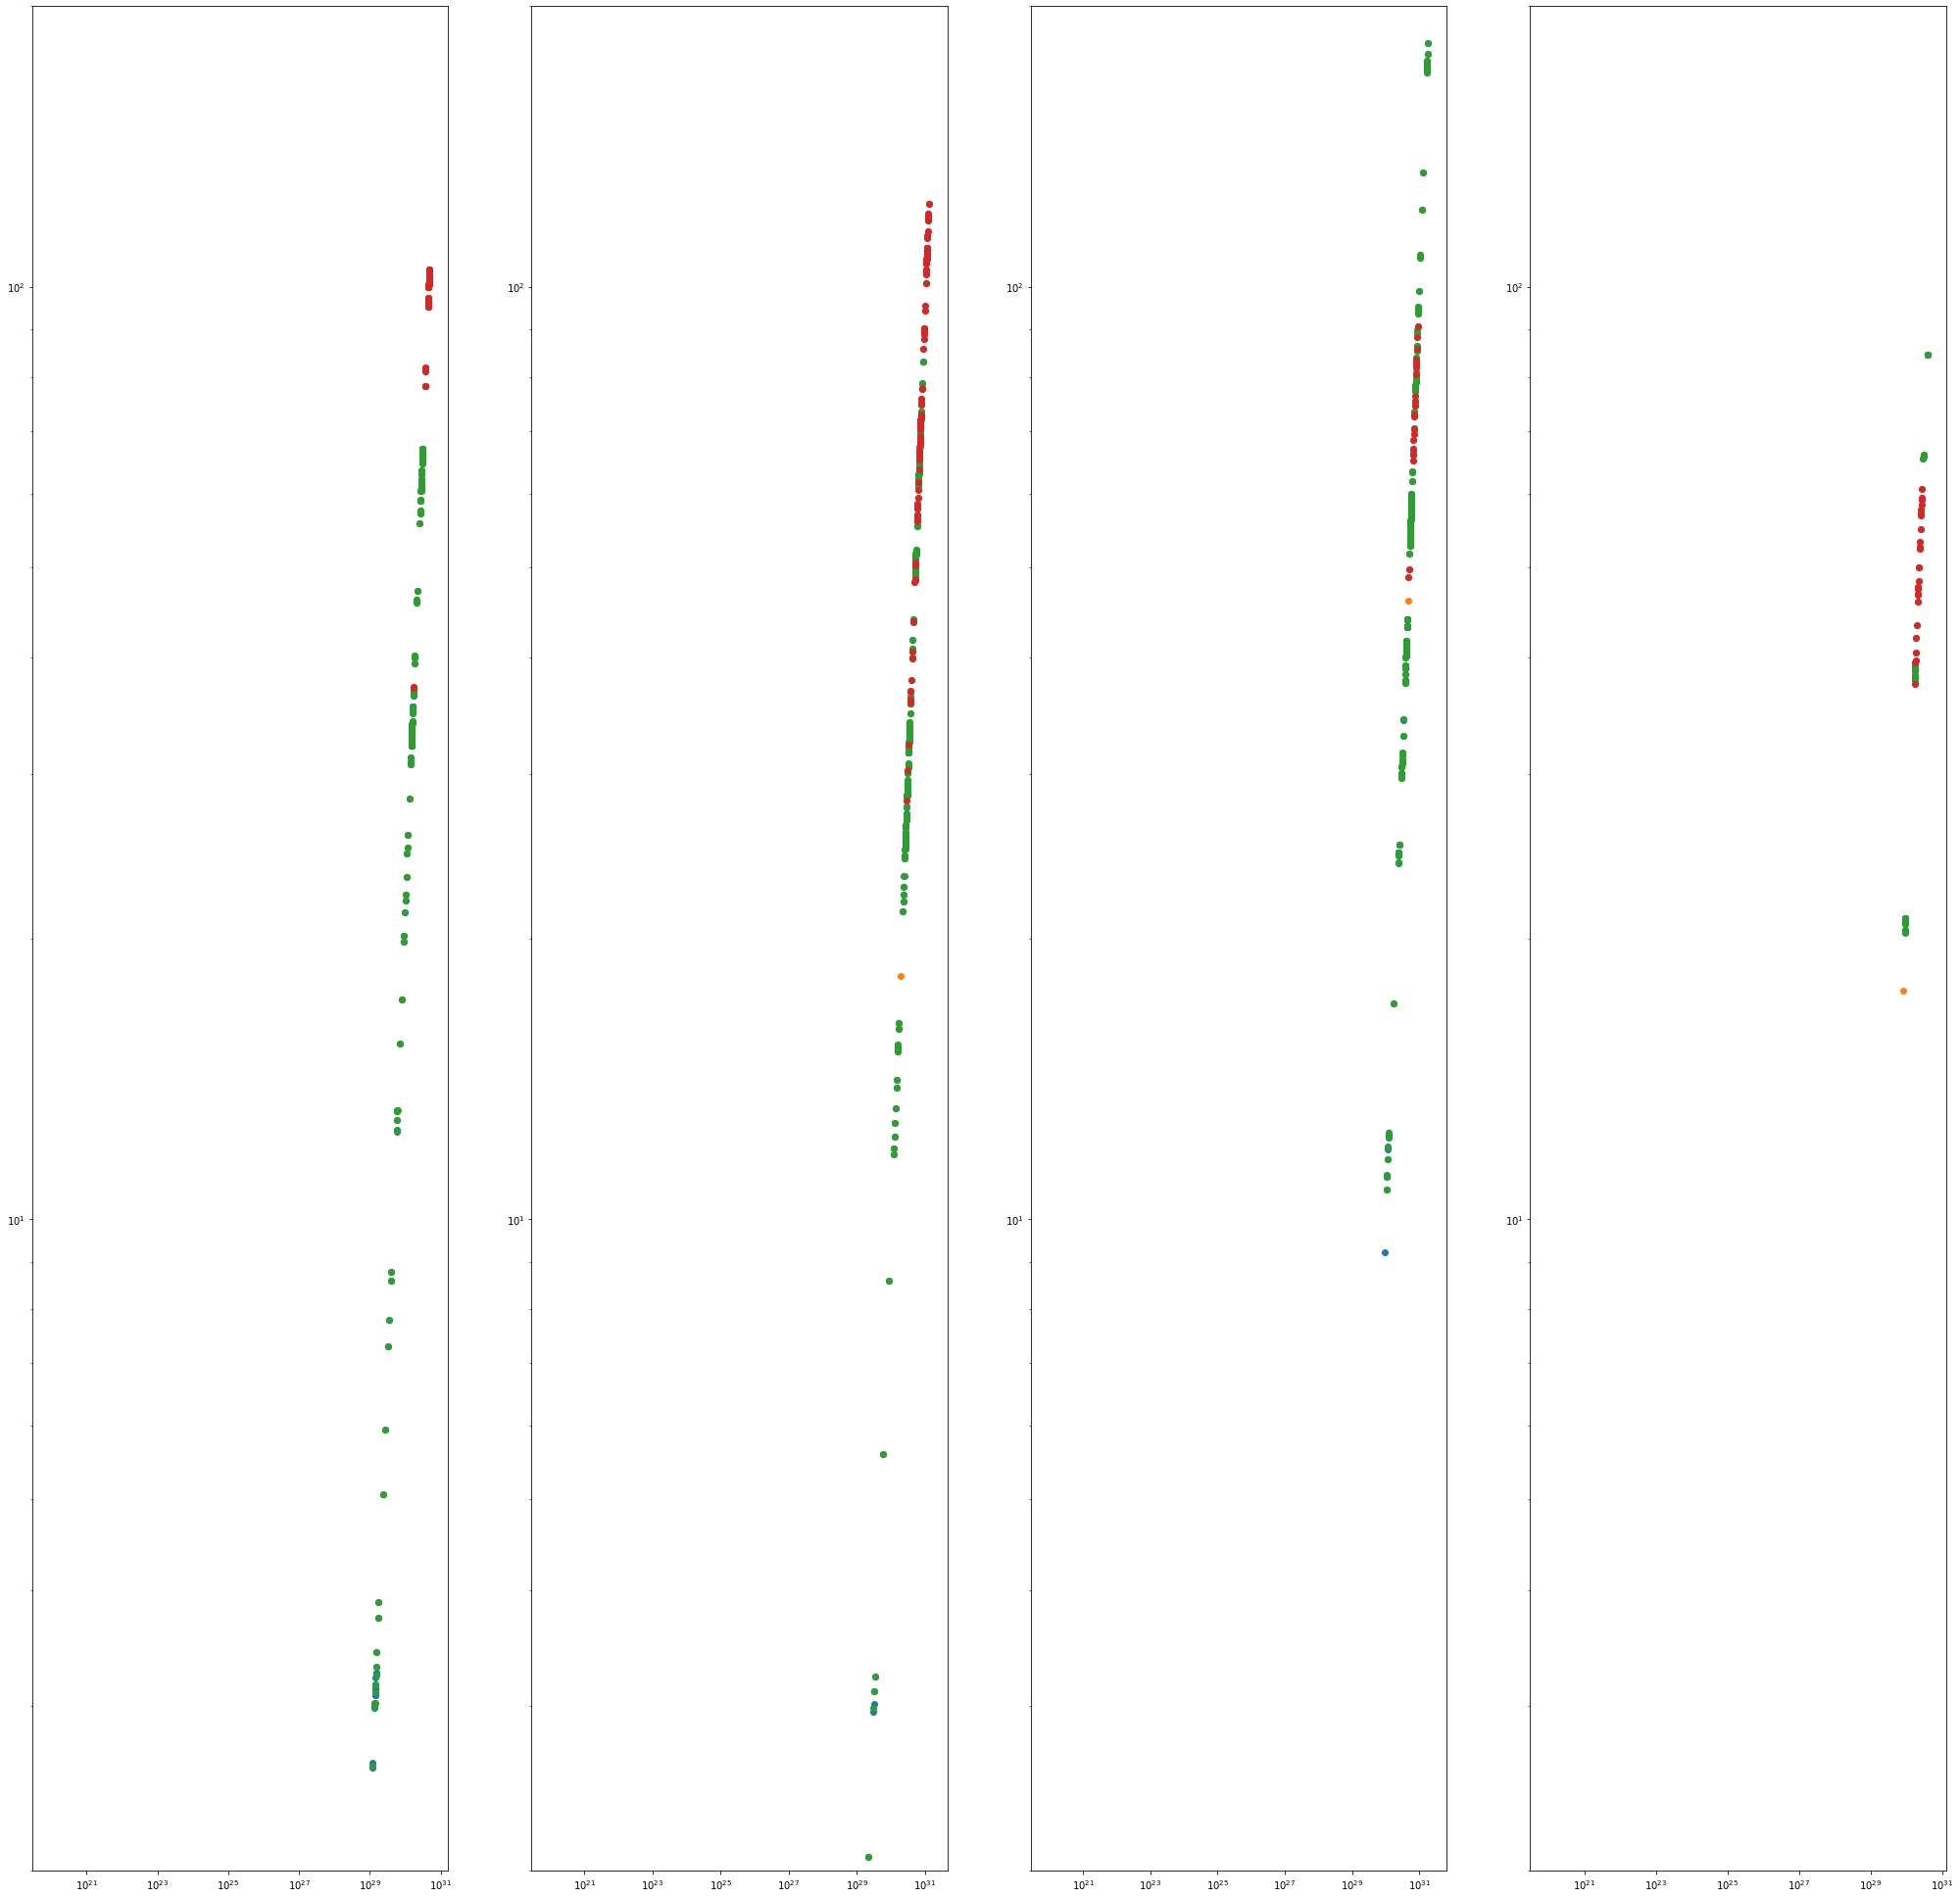

In [2]:
#Column densities

#Assume They are stable under their own gravity and follow the virial theorum (A_vir = 1)





RNames = np.load("RNames_CMZ.npy")
SNames = np.load("SNames_CMZ.npy")
CMZLs = ["HCO+_J1-0","HCN_J1-0","H13CN_J1-0","H13CO+_J1-0"]
NGCRNames = np.load("RNames.npy")
NGCSNames = np.load("SNames.npy")

#ONGCR = [NGCRNames[9],NGCRNames[10],NGCRNames[8],NGCRNames[5]]
#ONGCS = [NGCSNames[9],NGCSNames[10],NGCSNames[8],NGCSNames[5]]
ONGCR = [NGCRNames[0],NGCRNames[1],NGCRNames[2],NGCRNames[5]]
ONGCS = [NGCSNames[0],NGCSNames[1],NGCSNames[2],NGCSNames[5]]

Masses= [.0610168,.027,.028,.0620168] #Kg/mol Approximate

Bars = np.load("CZM_Beam_Area_Ratios.npy")
NBars = np.load("NGC_Beam_Area_Ratios.npy")

SpecRes = np.load("CZM_Sres.npy")
NSpecRes = np.load("NGC_Sres.npy")

SpRes= np.load("CZM_Spres.npy")
NSpRes = np.load("NGC_Spres.npy")

#for i in range(len(RNames)):
fig = plt.figure(1,figsize=(35,35))


for i in range(4):
    #Virial energy lines
    
    
    
    
        
    Number_of_bins=1000
    
    NsU=np.linspace(10**20,10**25,Number_of_bins)
    
    A_vir = 1
    f=5/3
    G = 6.67408*10**-11#*u.meter**3*u.kg**-1*u.s**-2# m3 kg-1 s-2
    s2_r=[]
    pc_2_m=3.086*10**16#*u.meter/u.parsec#m/pc
    
    AV_N = 6.02214076*10**23#molecules per mole
    
    Num_Per_Kg = AV_N/Masses[i]
    for t in range(Number_of_bins):
        ps = 0
        #N = 5/A_vir/f/np.pi*sigma**2/R
        #sigma**2/R = N/(5/A_vir/f/np.pi)
        Sig_sqr_over_R =  NsU[t]/(5/A_vir/G/f/np.pi)*pc_2_m/100000**2/Num_Per_Kg
        s2_r.append(Sig_sqr_over_R)
        
    #print(RNames,SNames,CMZLs,NGCRNames,NGCSNames)
    rnameL=RNames[i]+"_Leaves.npy"
    snameL=SNames[i]+"_Leaves.npy"
    rnameB=RNames[i]+"_Branches.npy"
    snameB=SNames[i]+"_Branches.npy"
    
    NGCrnameL=ONGCR[i]+"_Leaves.npy"
    NGCsnameL=ONGCS[i]+"_Leaves.npy"
    NGCrnameB=ONGCR[i]+"_Branches.npy"
    NGCsnameB=ONGCS[i]+"_Branches.npy"
    
    radsL = np.load(rnameL)*10**6#*u.parsec#pc
    sigsL = np.load(snameL)#*u.km/u.s
    radsB = np.load(rnameB)*10**6#*u.parsec#pc
    sigsB = np.load(snameB)#*u.km/u.s
    
    radsNGCL = np.load(NGCrnameL)*10**6#*u.parsec
    sigsNGCL = np.load(NGCsnameL)#*u.km/u.s
    radsNGCB = np.load(NGCrnameB)*10**6#*u.parsec
    sigsNGCB = np.load(NGCsnameB)#*u.km/u.s
    
    radsNGC=np.concatenate((radsNGCL,radsNGCB))
    sigsNGC = np.concatenate((sigsNGCL,sigsNGCB))
    rads,sigs=np.concatenate((radsL,radsB)), np.concatenate((sigsL,sigsB))
    
    #Ns_Calc = 5/A_vir/f/G/np.pi*sigs**2/rads/pc_2_m*100000**2*Num_Per_Kg
    #NGC_Ns_Calc = 5/A_vir/f/G/np.pi*sigsNGC**2/radsNGC/pc_2_m*100000**2*Num_Per_Kg
    Ns_Calc = 5/A_vir/f/G/np.pi*sigs**2/rads/pc_2_m*100000**2*Num_Per_Kg
    NGC_Ns_Calc = 5/A_vir/f/G/np.pi*sigsNGC**2/radsNGC/pc_2_m*100000**2*Num_Per_Kg
    
    
    
    bw = (np.nanmax(Ns_Calc)-np.nanmin(Ns_Calc))/Number_of_bins#N
    
    cp=np.nanmin(Ns_Calc)
    Bin_Rat=[]
    Rat_err=[]
    Bin_Ns=[]
    
    NBin_Rat=[]
    NRat_err=[]
    NBin_Ns=[]
    while(True):
        Ratbin=[]
        if(cp>max(Ns_Calc)):
            break
        for k in range(len(Ns_Calc)):
            if(Ns_Calc[k]>cp and Ns_Calc[k]<cp+bw):
                Ratbin.append(sigs[k]**2/rads[k])
        if(str(np.nanmean(Ratbin))!=str(np.nan) and str(np.nanmean(Ratbin))!= str(np.inf)):
            Bin_Rat.append(np.nanmean(Ratbin))
            Rat_err.append(np.nanstd(Ratbin))
            Bin_Ns.append(cp+bw/2)
        cp+=bw
    
    bw = (np.nanmax(NGC_Ns_Calc)-np.nanmin(NGC_Ns_Calc))/Number_of_bins#N
    
    cp=np.nanmin(NGC_Ns_Calc)
    
    while(True):
        NRatbin=[]
        if(cp>max(NGC_Ns_Calc)):
            break
        for k in range(len(NGC_Ns_Calc)):
            if(NGC_Ns_Calc[k]>cp and NGC_Ns_Calc[k]<cp+bw):
                NRatbin.append(sigsNGC[k]**2/radsNGC[k])
        
        if(str(np.nanmean(NRatbin))!=str(np.nan) and str(np.nanmean(NRatbin))!= str(np.inf)):
            NBin_Rat.append(np.nanmean(NRatbin))
            NRat_err.append(np.nanstd(NRatbin))
            NBin_Ns.append(cp+bw/2)
        cp+=bw
        
        
    fig = plt.figure(1,figsize=(15,15))
    
    ax = pylab.subplot(1,4, i+1)
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    #ax.set_xlim(10**4,10**4.5)
    ax.set_ylim(2,200)
    ax.plot(NsU,s2_r)
    ax.scatter(Ns_Calc,sigs**2/rads)
    ax.scatter(NGC_Ns_Calc,sigsNGC**2/radsNGC)
    ax.scatter(Bin_Ns,Bin_Rat)
    ax.scatter(NBin_Ns,NBin_Rat)
    

In [43]:
def make_plots(Num,Gal,Colors):
    
    RName = np.load("RNames_CMZ.npy")[Num]
    SName = np.load("SNames_CMZ.npy")[Num]
    
    CMZLs = ["HCO+_J1-0","HCN_J1-0","H13CN_J1-0","H13CO+_J1-0"]
    
    ONGCR = np.load("RNames.npy")[Num]
    ONGCS = np.load("SNames.npy")[Num]
    Bar = np.load("CZM_Beam_Area_Ratios.npy")[Num]
    NBar = np.load("NGC_Beam_Area_Ratios.npy")[Num]
    SpecRes = np.load("CZM_Sres.npy")[Num]
    NSpecRes = np.load("NGC_Sres.npy")[Num]

    SpRes= np.load("CZM_Spres.npy")[Num]
    NSpRes = np.load("NGC_Spres.npy")[Num]
    fig = plt.figure(1,figsize=(35,35))
    #make minimum space line

    ysp=2#SpecRes[i]
    xsp=SpRes*np.sqrt(Bar)#SpRes[i]
    Nysp=2#NSpecRes[i]
    Nxsp=NSpRes*np.sqrt(NBar)




    xsps=[]

    ysps=[]

    line=[]
    minsigs=[]
    Nxsps=[]

    Nysps=[]


    Nminsigs=[]
    zeros=[]

    rs=np.linspace(0.1,500,100)
    L=np.linspace(-1,20,10)
    for t in range(100):
        ps = 0
        xsps.append(xsp)
        ysps.append(ysp)

        Nxsps.append(Nxsp)
        Nysps.append(Nysp)

        Nminsigs.append(np.roots([rs[t]**2,-NSpecRes*3*NSpRes**2])[0]) #Solve for the minimum sigma value for a given radius
        minsigs.append(np.roots([rs[t]**2,-SpecRes*3*SpRes**2*2.0475**2*1.3807])[0])

        line.append(rs[t])
        zeros.append(-1)

    rnameNA = RName+"_NA.npy"
    snameNA = SName+"_NA.npy"

    NGCrnameNA = ONGCR+"_NA.npy"
    NGCsnameNA = ONGCS+"_NA.npy"

    radsNA = np.load(rnameNA)*10**6#pc
    sigsNA = np.load(snameNA)

    radsNGCNA = np.load(NGCrnameNA)*10**6
    sigsNGCNA = np.load(NGCsnameNA)



    rnameL=RName+"_Leaves.npy"
    snameL=SName+"_Leaves.npy"
    rnameB=RName+"_Branches.npy"
    snameB=SName+"_Branches.npy"

    NGCrnameL=ONGCR+"_Leaves.npy"
    NGCsnameL=ONGCS+"_Leaves.npy"
    NGCrnameB=ONGCR+"_Branches.npy"
    NGCsnameB=ONGCS+"_Branches.npy"

    radsL = np.load(rnameL)*10**6#pc
    sigsL = np.load(snameL)
    radsB = np.load(rnameB)*10**6#pc
    sigsB = np.load(snameB)

    radsNGCL = np.load(NGCrnameL)*10**6
    sigsNGCL = np.load(NGCsnameL)
    radsNGCB = np.load(NGCrnameB)*10**6
    sigsNGCB = np.load(NGCsnameB)

    radsNGC=np.concatenate((radsNGCL,radsNGCB))
    sigsNGC = np.concatenate((sigsNGCL,sigsNGCB))
    rads,sigs=np.concatenate((radsL,radsB)), np.concatenate((sigsL,sigsB))

    from scipy.optimize import curve_fit

    def func(R,a,b):
        return a*R**(b)

    (poptT, pcovT) =(curve_fit(func, rads,sigs))

    (NpoptT, NpcovT) = (curve_fit(func, radsNGC,sigsNGC ))


    poptNA,pcovNA = curve_fit(func, radsNA, sigsNA)
    NpoptNA,NpcovNA = curve_fit(func, radsNGCNA, sigsNGCNA)

    axA = pylab.subplot(3,5, i+1)

    axNM = pylab.subplot(3,5, i+6)

    axNA = pylab.subplot(3,5, i+11)
    #No abs both
    xsNAp = axNA.scatter(radsNA, sigsNA,c="Black",alpha=.7,label=("CMZ_No_Abs_All "+CMZLs[Num]),marker='x',s=20)
    NxsNAp = axNA.scatter(radsNGCNA, sigsNGCNA,c="Green",alpha=.7,label=("NGC_No_Abs_All "+CMZLs[Num]),marker='x',s=20)
    xsNA=np.linspace(np.nanmin(radsNA),np.nanmax(radsNA),50)
    ysNA=func(xsNA,poptNA[0],poptNA[1])
    xpaNA = axNA.plot(xsNA,ysNA,c='Black',label='CMZ_No_Abs_All')
    
    NxsNA=np.linspace(np.nanmin(radsNGCNA),np.nanmax(radsNGCNA),50)
    NysNA=func(NxsNA,NpoptNA[0],NpoptNA[1])
    NxpaNA = axNA.plot(NxsNA,NysNA,c='Green',label='NGC_No_Abs_All')
    
    er_r=2
    yusNA  = func(xsNA, poptNA[0]+np.sqrt(pcovNA[0][0])*er_r,poptNA[1]+np.sqrt(pcovNA[1][1])*er_r)
    ylsNA  = func(xsNA, poptNA[0]-np.sqrt(pcovNA[0][0])*er_r,poptNA[1]-np.sqrt(pcovNA[1][1])*er_r)
    xpaFNA = axNA.fill_between(xsNA,ylsNA,yusNA,color="Black",alpha=.2)
    
    NyusNA  = func(NxsNA, NpoptNA[0]+np.sqrt(NpcovNA[0][0])*er_r,NpoptNA[1]+np.sqrt(NpcovNA[1][1])*er_r)
    NylsNA  = func(NxsNA, NpoptNA[0]-np.sqrt(NpcovNA[0][0])*er_r,NpoptNA[1]-np.sqrt(NpcovNA[1][1])*er_r)
    NxpaFNA = axNA.fill_between(NxsNA,NylsNA,NyusNA,color="Green",alpha=.2)
    
    
    xs=np.linspace(np.nanmin(rads),np.nanmax(rads),50)
    ysT=func(xs,poptT[0],poptT[1])
    xpaT = axA.plot(xs,ysT,c='Blue')
    xpas = axA.scatter(rads,sigs,c='Blue',label='CMZ_All',s=10,alpha=.7)
    xpaT2 = axNA.plot(xs,ysT,c='Blue')
    xpas2 = axNA.scatter(rads,sigs,c='Blue',label='CMZ_All',s=7,alpha=.5)
    



    er_r=2
    yusT  = func(xs, poptT[0]+np.sqrt(pcovT[0][0])*er_r,poptT[1]+np.sqrt(pcovT[1][1])*er_r)
    ylsT  = func(xs, poptT[0]-np.sqrt(pcovT[0][0])*er_r,poptT[1]-np.sqrt(pcovT[1][1])*er_r)
    xpaFT = axA.fill_between(xs,ylsT,yusT,color="Blue",alpha=.4)
    xpaFT2 = axNA.fill_between(xs,ylsT,yusT,color="Blue",alpha=.2)

    cmzT2F = axNM.fill_between(xs,ylsT,yusT,color="Blue",alpha=.3)
    cmzT2 = axNM.plot(xs,ysT,c='Blue',label='CMZ_All')
    
    
    Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
    NysT=func(Nxs,NpoptT[0],NpoptT[1])
    NxpaT = axA.plot(Nxs,NysT,c='Red')
    Nxpas = axA.scatter(radsNGC,sigsNGC,c='Red',label='NGC_All',s=10,alpha=.7)
    NxpaT2 = axNA.plot(Nxs,NysT,c='Red')
    Nxpas2 = axNA.scatter(radsNGC,sigsNGC,c='Red',label='NGC_All',s=7,alpha=.5)

    er_r=2
    NyusT  = func(Nxs, NpoptT[0]+np.sqrt(NpcovT[0][0])*er_r,NpoptT[1]+np.sqrt(NpcovT[1][1])*er_r)
    NylsT  = func(Nxs, NpoptT[0]-np.sqrt(NpcovT[0][0])*er_r,NpoptT[1]-np.sqrt(NpcovT[1][1])*er_r)
    NxpaFT = axA.fill_between(Nxs,NylsT,NyusT,color="Red",alpha=.4)
    NxpaFT2 = axNA.fill_between(Nxs,NylsT,NyusT,color="Red",alpha=.2)



    #Plot NM data

    NysNM = func(Nxs,C_Ngc,E_Ngc)
    NysNM_U = func(Nxs, C_Ngc+(C_Ngc_Err)*er_r,E_Ngc+(E_Ngc_Err)*er_r)
    NysNM_L = func(Nxs, C_Ngc-(C_Ngc_Err)*er_r,E_Ngc-(E_Ngc_Err)*er_r)

    ngcT2F = axNM.fill_between(Nxs,NylsT,NyusT,color="Red",alpha=.3)
    ngcT2 = axNM.plot(Nxs,NysT,c='Red',label='NGC_All')

    Shetty_Exp = [0.64,0.46,.78,-5]
    Shetty_exp_errs = .06

    ShettyCoefs = [2.1,3.8,2.6,-5]
    ShettyCoefsErrs = 1.2
    SP = func(Nxs,ShettyCoefs[i],Shetty_Exp[i])
    SPU = func(Nxs,ShettyCoefs[i]+ShettyCoefsErrs*er_r,Shetty_Exp[i] + Shetty_exp_errs*er_r)
    SPL = func(Nxs,ShettyCoefs[i]-ShettyCoefsErrs*er_r,Shetty_Exp[i] - Shetty_exp_errs*er_r)
    ShettyNM = axNM.plot(Nxs,SP,c='Yellow',label='Shetty Values')
    ShettyFill = axNM.fill_between(Nxs,SPL,SPU,color="Yellow",alpha=.2)

    NicoCO = .74
    NicoCOErr=.04
    NicoCO_10= 3.3
    NicoCO_10Err= .4

    def NicoCOCoef(sig10,exp):
        return sig10/10**exp
    NNicoCO = .82
    NNicoCOErr=.02
    NNicoCO_10= 8.9
    NNicoCO_10Err= .2

    NI = func(Nxs,NicoCOCoef(NicoCO_10,NicoCO),NicoCO)
    NIU = func(Nxs,NicoCOCoef(NicoCO_10+NicoCO_10Err*er_r,NicoCO+NicoCOErr*er_r),NicoCO+ NicoCOErr*er_r)
    NIL = func(Nxs,NicoCOCoef(NicoCO_10-NicoCO_10Err*er_r,NicoCO-NicoCOErr*er_r),NicoCO- NicoCOErr*er_r)

    NicoNM = axNM.plot(Nxs,NI,c='Cyan',label='Nico CO_1-0 Values_CMZ')
    NicoFill = axNM.fill_between(Nxs,NIL,NIU,color="Cyan",alpha=.2)

    NNI = func(Nxs,NicoCOCoef(NNicoCO_10,NNicoCO),NNicoCO)
    NNIU = func(Nxs,NicoCOCoef(NNicoCO_10+NNicoCO_10Err*er_r,NNicoCO+NNicoCOErr*er_r),NNicoCO+ NNicoCOErr*er_r)
    NNIL = func(Nxs,NicoCOCoef(NNicoCO_10-NNicoCO_10Err*er_r,NNicoCO-NNicoCOErr*er_r),NNicoCO- NNicoCOErr*er_r)

    NNicoNM = axNM.plot(Nxs,NNI,c='Orange',label='Nico CO_1-0 Values_NGC')
    NNicoFill = axNM.fill_between(Nxs,NNIL,NNIU,color="Orange",alpha=.2)


    axA.set_xlabel("Radius (pc)")
    axA.set_ylabel("Sigma (km/s)")
    axNA.set_xlabel("Radius (pc)")
    axNA.set_ylabel("Sigma (km/s)")
    axNM.set_xlabel("Radius (pc)")
    axNM.set_ylabel("Sigma (km/s)")
    axA.set_yscale('log')
    axA.set_xscale('log')
    axNA.set_yscale('log')
    axNA.set_xscale('log')
    axNM.set_yscale('log')
    axNM.set_xscale('log')
    axA.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=12,xy=(0.01,0.12),xycoords="axes fraction")  
    axNM.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=12,xy=(0.01,0.21),xycoords="axes fraction")
    axNA.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=12,xy=(0.01,0.21),xycoords="axes fraction")
    stA= ("CMZ: a="+str(round(poptT[0],5))+" =+-" + str(round(np.sqrt(pcovT[0][0]),5)) +", b="+str(round(poptT[1],5))+"+-" + str(round(np.sqrt(pcovT[1][1]),5)) )
    stNA= ("CMZ_No_abs: a="+str(round(poptNA[0],5))+" =+-" + str(round(np.sqrt(pcovNA[0][0]),5)) +", b="+str(round(poptNA[1],5))+"+-" + str(round(np.sqrt(pcovNA[1][1]),5)) )
    stNM= ("CMZ (NM avg): a="+str(round(C_Cmz,5))+" =+-" + str(round(C_Cmz_Err,5)) +", b="+str(round(E_Cmz,5))+"+-" + str(round(E_Cmz_Err,5)) )
    axA.set_xlim(np.nanmin(rads)*.5,np.nanmax(rads)*1.1)
    axA.set_ylim(np.nanmin(sigs)*.9,np.nanmax(sigs)*1.4)
    axNA.set_xlim(np.nanmin(radsNA)*.5,np.nanmax(radsNA)*1.1)
    axNA.set_ylim(np.nanmin(sigsNA)*.9,np.nanmax(sigsNA)*1.4)
    axNM.set_xlim(np.nanmin(rads)*.9,np.nanmax(rads)*1.1)
    axNM.set_ylim(np.nanmin(sigs),np.nanmax(sigs)*1.5)
    NstA= ("NGC253: a="+str(round(NpoptT[0],5))+"+-" + str(round(np.sqrt(NpcovT[0][0]),5)) +", b="+str(round(NpoptT[1],5))+"+-" + str(round(np.sqrt(NpcovT[1][1]),5)) )
    NstNM= ("NGC253 (NM avg): a="+str(round(C_Ngc,5))+" =+-" + str(round(C_Ngc_Err,5)) +", b="+str(round(E_Ngc,5))+"+-" + str(round(E_Ngc_Err,5)) )
    NstNA= ("NGC_No_abs: a="+str(round(NpoptNA[0],5))+" =+-" + str(round(np.sqrt(NpcovNA[0][0]),5)) +", b="+str(round(NpoptNA[1],5))+"+-" + str(round(np.sqrt(NpcovNA[1][1]),5)) )
    axA.annotate(s=stA,fontsize=12,xy=(0.01,0.08),xycoords="axes fraction")  

    axA.annotate(s=NstA,fontsize=12,xy=(0.01,0.01),xycoords="axes fraction") 
    
    axNA.annotate(s=stA,fontsize=10,xy=(0.01,0.02),xycoords="axes fraction")  

    axNA.annotate(s=NstA,fontsize=10,xy=(0.01,0.04),xycoords="axes fraction") 

    axA.annotate(s="Beam size",fontsize=12,xy=(0.01,0.2),xycoords="axes fraction",rotation='vertical') 


    #axNM.annotate(s=stNM,fontsize=10,xy=(0.01,0.06),xycoords="axes fraction")  

    #axNM.annotate(s=NstNM,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction") 
    axNM.annotate(s=stA,fontsize=10,xy=(0.01,0.11),xycoords="axes fraction")  

    axNM.annotate(s=NstA,fontsize=10,xy=(0.01,0.16),xycoords="axes fraction") 
    
    axNA.annotate(s=stNA,fontsize=10,xy=(0.01,0.06),xycoords="axes fraction")  

    axNA.annotate(s=NstNA,fontsize=10,xy=(0.01,0.08),xycoords="axes fraction") 

    axA.legend(loc='upper left')
    axNM.legend(loc='upper left')
    axNA.legend(loc='upper left')
    axA.title.set_text((CMZLs[Num]+" Velocity Dispersion as a function of Radius"))
    axNM.title.set_text((CMZLs[Num]+" Velocity Dispersion as a function of Radius"))
    axNA.title.set_text((CMZLs[Num]+" Velocity Dispersion as a function of Radius"))

    
    NxminF1,NxminF2,NxminF3,NxminF4 = axA.fill_betweenx(line,Nxsps,zeros,color="gray",alpha=.1),axB.fill_betweenx(line,Nxsps,zeros,color="gray",alpha=.1),axL.fill_betweenx(line,Nxsps,zeros,color="gray",alpha=.1),ax4.fill_betweenx(line,Nxsps,zeros,color="gray",alpha=.1)
    xminF1,xminF2,xminF3,xminF4 = axA.fill_betweenx(line,xsps,zeros,color="gray",alpha=.1),axB.fill_betweenx(line,xsps,zeros,color="gray",alpha=.1),axL.fill_betweenx(line,xsps,zeros,color="gray",alpha=.1),ax4.fill_betweenx(line,xsps,zeros,color="gray",alpha=.1)


    #Plot virial expected sigma-r relation ship, ref: https://arxiv.org/pdf/2008.02518.pdf 5.1


    fig.savefig(bbox_inches='tight',fname="Comparison Plots.jpeg")


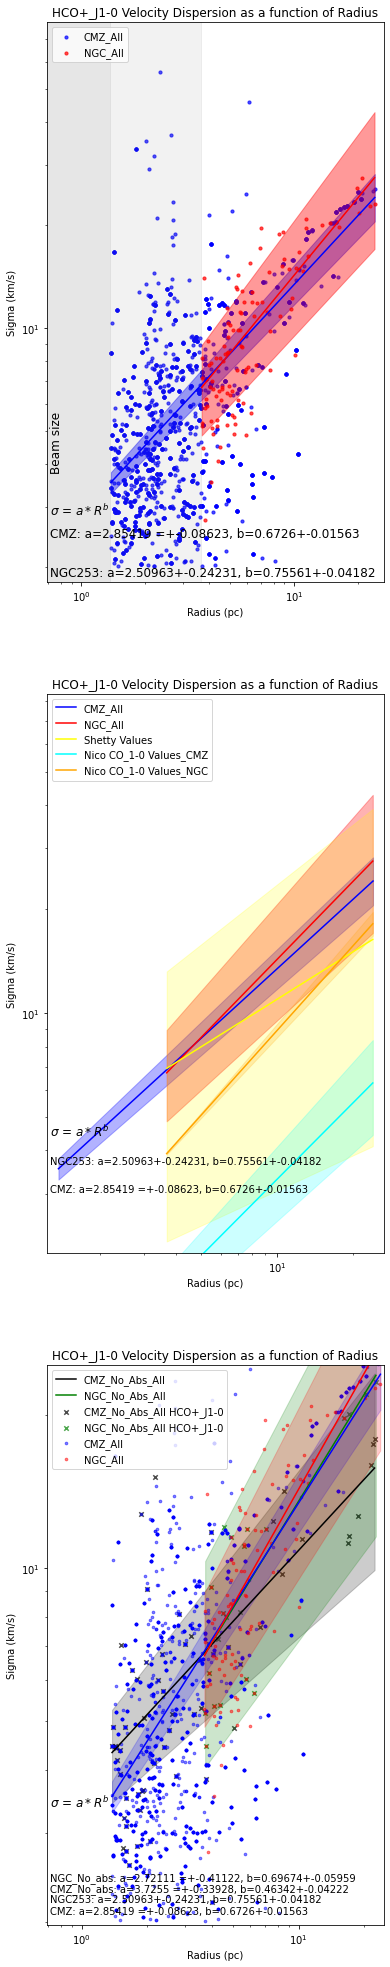

In [45]:
make_plots(0,1,1)